# Detecting BDM In Superbowl Commercials

## Notebook Settings

In [1]:

%pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 10.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 10.8 MB/s eta 0:00:0000:0100:01
You should consider upgrading via the '/home/arkastor/Development/Commercial-Brand-Differentiating-Message-Analysis/app/.venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import os

In [3]:
import logging
from datetime import datetime

logging.basicConfig(
    filename='log.log',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

def update_df_with_csv(df, csv_filepath, merge_key):
    """
    Update the dataframe by merging with data from a CSV file.
    Prefers the incoming CSV's columns when there's a conflict.

    Parameters:
    - df: DataFrame to update.
    - csv_filepath: Path to the CSV file to merge with.
    - merge_key: Column name to merge on.

    Returns:
    - Updated DataFrame.
    """
    # Read CSV file
    incoming_df = pd.read_csv(csv_filepath)
    
    # Merge with suffixes to identify incoming columns
    updated_df = df.merge(incoming_df, on=merge_key, how='left', suffixes=('', '_incoming'))
    
    # Handle conflicts: drop original columns and rename incoming columns
    conflicting_columns = [col for col in incoming_df.columns if col in df.columns and col != merge_key]
    for col in conflicting_columns:
        updated_df.drop(col, axis=1, inplace=True)  # Drop the original column
        updated_df.rename(columns={f'{col}_incoming': col}, inplace=True)  # Rename the incoming column
    
    return updated_df

In [4]:
# We have some specific knowledge about the industry and brand, so we can use that to improve the model. This data only exists for a few brands and products. Activate or deactivate as needed.

# Activate if you want to reduce the selection of commercials to 20 for debugging

DEBUGGING = False

CSV_PATH = 'csvs'

In [5]:
# Activate if you want to completely rerun the notebook from scratch. This will delete all csvs/ saved data and start from scratch.
RESTART_FROM_SCRATCH = False
import shutil
csv_dir = "./csvs"
if RESTART_FROM_SCRATCH and os.path.exists(csv_dir):
    shutil.rmtree(csv_dir)
    logging.info(f"Directory '{csv_dir}' has been deleted.")

In [6]:
# Checkpoints
# Since the model takes very long to train, we save extracted features to csvs and only rerun the code if the csv "checkpoint" does not exist

BASELINE_CHECKPOINT = os.path.exists(f'{CSV_PATH}/baseline.csv')
logging.info(f"Baseline checkpoint: {BASELINE_CHECKPOINT}")
TRANSCRIPT_CHECKPOINT = os.path.exists(f'{CSV_PATH}/transcript.csv')
logging.info(f"Transcript checkpoint: {TRANSCRIPT_CHECKPOINT}")
OCR_CHECKPOINT = os.path.exists(f'{CSV_PATH}/ocr.csv')
logging.info(f"OCR checkpoint: {OCR_CHECKPOINT}")
BDM_WORDS_CHECKPOINT = os.path.exists(f'{CSV_PATH}/bdm_words.csv')
logging.info(f"BDM words checkpoint: {BDM_WORDS_CHECKPOINT}")
ADJ_NOUN_PAIRS_CHECKPOINT = os.path.exists(f'{CSV_PATH}/adj_noun_pairs.csv')
logging.info(f"Adj noun pairs checkpoint: {ADJ_NOUN_PAIRS_CHECKPOINT}")
PRODUCT_SEMANTIC_SIMILARITY_CHECKPOINT = os.path.exists(f'{CSV_PATH}/product_semantic_similarity.csv')
logging.info(f"Product semantic similarity checkpoint: {PRODUCT_SEMANTIC_SIMILARITY_CHECKPOINT}")
BRAND_SEMANTIC_SIMILARITY_CHECKPOINT = os.path.exists(f'{CSV_PATH}/brand_semantic_similarity.csv')
logging.info(f"Brand semantic similarity checkpoint: {BRAND_SEMANTIC_SIMILARITY_CHECKPOINT}")
PERSONAL_PRONOUNS_CHECKPOINT = os.path.exists(f'{CSV_PATH}/personal_pronouns.csv')
logging.info(f"Personal pronouns checkpoint: {PERSONAL_PRONOUNS_CHECKPOINT}")
COMPARISONS_CHECKPOINT = os.path.exists(f'{CSV_PATH}/comparisons.csv')
logging.info(f"Comparisons checkpoint: {COMPARISONS_CHECKPOINT}")



# CRISP-DM 3: Data Preparation

In [7]:

def download_videos():
  url = 'https://box.fu-berlin.de/s/zwxKp8PXkCwAwGe/download'
  download_filename = 'downloaded_archive.zip'
  target_directory = 'ADs'
  os.system(f'wget -O {download_filename} {url}')
  os.makedirs(target_directory, exist_ok=True)
  os.system(f'unzip -o {download_filename} -d {target_directory}')
  os.remove(download_filename)
  logging.info(f"Archive extracted to {target_directory} and {download_filename} removed.")

if not BASELINE_CHECKPOINT:
  pass
  download_videos()

In [8]:
ad_df = pd.DataFrame()
if not BASELINE_CHECKPOINT:
    BDM_excel = pd.read_excel('BDM.xlsx')
    final_excel = pd.read_excel('previous_project_results.xlsx')
    final_excel = final_excel.merge(
    BDM_excel[['AdNumber', 'BDM']], 
    on='AdNumber', 
    how='left',
    suffixes=('_old', '')
    ).drop('BDM_old', axis=1, errors='ignore')
    ad_df = final_excel
    ad_df = ad_df[['cont_primary_product_type', 'BRAND', 'AdNumber', 'cont_com_appeal', 'cont_csr_type', 'Emotion_from_Dialogue', 'BDM']]
    ad_df = ad_df.rename(columns={'cont_primary_product_type': 'product_category', 'BRAND': 'brand', 'AdNumber': 'commercial_number', 'cont_com_appeal': 'commercial_appeal', 'cont_csr_type': 'csr_type', 'Emotion_from_Dialogue': 'emotion_from_dialogue'})  # Changed here
    ad_df.head(10)
    # Manual coding by the marketing team: 1 = rational, 2 = balanced, 3 = emotional
    sentiment_columns = ad_df["commercial_appeal"]

    # Sentiment analysis from the last project group for audio transcription
    # Encoding 0: p < 0.8 = neutral
    # Encoding 1: p > 0.8 = emotional

    emotion_columns = ad_df["emotion_from_dialogue"]

    # List of values to be encoded as 1
    target_emotions = ['love', 'joy', 'surprise', 'sadness', 'anger', 'fear']
    ad_df.loc[:, 'encoded_emotion'] = emotion_columns.apply(lambda x: 1 if x in target_emotions else 0)  # Changed here
    ad_df = ad_df.drop(['emotion_from_dialogue', 'commercial_appeal'], axis=1)

    # List of commercial numbers to update
    commercial_numbers = ['AD0262', 'AD0284', 'AD0332', 'AD0348', 'AD0370', 'AD0375', 'AD0399', 'AD0482', 'AD0539', 'AD0749']
    ad_df.loc[ad_df['commercial_number'].isin(commercial_numbers), 'BDM'] = 1.0

    # delete row with commercial number AD0633
    ad_df = ad_df[ad_df['commercial_number'] != 'AD0633']
    ad_df = ad_df[ad_df['commercial_number'] != 'AD0742']
    # drop all rows with no commercial number
    ad_df = ad_df[ad_df['commercial_number'].notna()]
    display(ad_df.head(10))

## Brand Keywords

In [9]:
if not BASELINE_CHECKPOINT:
        product_brand_df = pd.read_csv("product_brands.csv")

        product_brand_df['brand'] = product_brand_df['brand'].str.replace(' ', '').str.lower()
        ad_df['brand_clean'] = ad_df['brand'].str.replace(' ', '').str.lower()

        ad_df = ad_df.merge(
            product_brand_df[['brand', 'product_brand_keywords']], 
            left_on='brand_clean',
            right_on='brand',
            how='left',
            suffixes=('', '_brand')
        )

        ad_df.drop(['brand_clean', 'brand_brand'], axis=1, inplace=True)


## Product Category Keywords

In [10]:
if not BASELINE_CHECKPOINT:
        product_brands_df = pd.read_csv("product_categories.csv")
        product_brands_df = product_brands_df.drop('product_cat_id', axis=1)
        ad_df = ad_df.drop('product_category', axis=1)
        display(product_brands_df)
        display(ad_df)
        brand_to_info = {}
        for _, row in product_brands_df.iterrows():
            brands = eval(row['product_cat_brands'])
            for brand in brands:
                brand = brand.replace(' ', '').lower()
                brand_to_info[brand] = {col: row[col] for col in product_brands_df.columns}

        def find_brand_info(brand):
            if pd.isna(brand):
                return None
            clean_brand = brand.replace(' ', '').lower()
            return brand_to_info.get(clean_brand)

        for col in product_brands_df.columns:
            ad_df[col] = ad_df['brand'].apply(lambda x: find_brand_info(x)[col] if find_brand_info(x) else None)

        unmapped_brands = ad_df[ad_df['product_cat_name'].isna()]['brand'].unique()
        if len(unmapped_brands) > 0:
            logging.info("Brands without category mapping:")
            for brand in unmapped_brands:
                logging.info(f"- {brand}")

        ad_df.head(10)
        # drop all where product_cat_name is nan


In [11]:
# Debugging
if not BASELINE_CHECKPOINT:
    if DEBUGGING:
        ad_df = ad_df.head(20)

In [12]:
BASELINE_COLUMNS = ad_df.columns
if not BASELINE_CHECKPOINT:
  os.makedirs(f'{CSV_PATH}', exist_ok=True)
  ad_df[BASELINE_COLUMNS].to_csv(f'{CSV_PATH}/baseline.csv', index=False)

## Feature Extraction

In [13]:
ad_df = pd.read_csv(f'{CSV_PATH}/baseline.csv')

### Feature: Transcript

In [14]:
import glob
from pathlib import Path
from transcript import transcribe_video
from ocr import ocr
TRANSCRIPT_COLUMNS = ['transcript']
if not TRANSCRIPT_CHECKPOINT:
    ads_dir = "ADs"
    def find_video_file(commercial_number, ads_dir):
        """Find the video file path for a given commercial number."""
        # Search recursively for MP4 files
        pattern = f"{ads_dir}/**/{commercial_number}.mp4"
        matches = glob.glob(pattern, recursive=True)
        return matches[0] if matches else None

    # Initialize a list to collect indices of rows to drop
    rows_to_drop = []

    for idx, row in ad_df.iterrows():
        # this is to prevent nans in the csv 
        transcript = ' '
        commercial_number = row['commercial_number']
        video_path = find_video_file(commercial_number, ads_dir)
        
        if video_path:
            transcript = transcribe_video(video_path)
            ad_df.at[idx, 'transcript'] = transcript
        else:
            logging.info(f"Video not found for commercial {commercial_number}")
            # Collect index of row to drop
            rows_to_drop.append(idx)

    # Drop the rows where no video was found
    ad_df = ad_df.drop(rows_to_drop)
    ad_df[TRANSCRIPT_COLUMNS + ['commercial_number']].to_csv(f'{CSV_PATH}/transcript.csv', index=False)
    ad_df.head(10)

/home/arkastor/Development/Commercial-Brand-Differentiating-Message-Analysis/app/.venv/lib/python3.9/site-packages/whisper/__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimenta

In [15]:
ad_df = update_df_with_csv(ad_df, f'{CSV_PATH}/transcript.csv', 'commercial_number')
ad_df['transcript'] = ad_df['transcript'].fillna('')


### Feature: OCR

In [16]:
# Import necessary libraries
import glob
import pandas as pd
from pathlib import Path
from transcript import transcribe_video
from ocr import ocr

OCR_COLUMNS = ['ocr_text']

if not OCR_CHECKPOINT:
    ads_dir = "ADs"
    temp_csv_path = f'{CSV_PATH}/ocr_temp.csv'
    
    # Load existing OCR data if available
    if Path(temp_csv_path).exists():
        ocr_temp_df = pd.read_csv(temp_csv_path)
    else:
        ocr_temp_df = pd.DataFrame(columns=['commercial_number', 'ocr_text'])

    def find_video_file(commercial_number, ads_dir):
        """Find the video file path for a given commercial number."""
        # Search recursively for MP4 files
        pattern = f"{ads_dir}/**/{commercial_number}.mp4"
        matches = glob.glob(pattern, recursive=True)
        return matches[0] if matches else None

    # Process only rows where 'ocr_text' is empty
    for idx, row in ocr_temp_df.iterrows():
        if pd.isna(row['ocr_text']):
            commercial_number = row['commercial_number']
            video_path = find_video_file(commercial_number, ads_dir)
            # set to empty string if ocr text is empty, '' results in nans in the csv. therefore we set it to ' '
            ocr_text = ' '  # Initialize OCR text as empty string
            
            if video_path:
                if DEBUGGING:
                    ocr_text = ' '  # Use empty string for debugging
                else:
                    logging.info(f"Performing OCR on {video_path}")
                    ocr_text = ocr(video_path)  # Perform OCR on the video file
                    if ocr_text == '':
                        ocr_text = ' '
            else:
                logging.info(f"Video not found for commercial {commercial_number}")

            # Update the OCR text in the DataFrame
            ocr_temp_df.at[idx, 'ocr_text'] = ocr_text
            ocr_temp_df.to_csv(f'{CSV_PATH}/ocr_temp.csv', index=False)

    # Save all OCR results to final CSV after processing all videos
    ocr_temp_df.to_csv(f'{CSV_PATH}/ocr.csv', index=False)

In [17]:
ad_df = update_df_with_csv(ad_df, f'{CSV_PATH}/ocr.csv', 'commercial_number')

ad_df['ocr_text'] = ad_df['ocr_text'].fillna('')

### Feature: Superlatives, Comparatives, Uniqueness

In [18]:
!python -m spacy download en_core_web_sm

  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.8.0/en_core_web_sm-3.8.0-py3-none-any.whl (12.8 MB)
You should consider upgrading via the '/home/arkastor/Development/Commercial-Brand-Differentiating-Message-Analysis/app/.venv/bin/python -m pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [19]:
import spacy
import pandas as pd
from collections import Counter
import text_analysis as ta

BDM_WORDS_COLUMNS = ['transcript_superlatives', 'transcript_comparatives', 'transcript_unique_words', 'transcript_superlative_count', 'transcript_comparative_count', 'transcript_uniqueness_count', 'transcript_superlative_pct', 'transcript_comparative_pct', 'transcript_uniqueness_pct', 'transcript_total_bdm_terms_count', 'transcript_total_bdm_terms_pct', 'ocr_text_superlatives', 'ocr_text_comparatives', 'ocr_text_unique_words', 'ocr_text_superlative_count', 'ocr_text_comparative_count', 'ocr_text_uniqueness_count', 'ocr_text_superlative_pct', 'ocr_text_comparative_pct', 'ocr_text_uniqueness_pct', 'ocr_text_total_bdm_terms_count', 'ocr_text_total_bdm_terms_pct']


if not BDM_WORDS_CHECKPOINT:
    ad_df = ta.process_text_data(ad_df, 'transcript')
    ad_df = ta.process_text_data(ad_df, 'ocr_text')

    columns = ['commercial_number'] + BDM_WORDS_COLUMNS
    ad_df[columns].to_csv(f'{CSV_PATH}/bdm_words.csv', index=False)

/home/arkastor/Development/Commercial-Brand-Differentiating-Message-Analysis/app/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-02-05 15:08:10.810322: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-05 15:08:10.816839: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738764490.824319  230931 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E

In [20]:
ad_df = update_df_with_csv(ad_df, f'{CSV_PATH}/bdm_words.csv', 'commercial_number')

# fillna object columns with empty string, float columns with 0
for column in ad_df[BDM_WORDS_COLUMNS].columns:
    if ad_df[column].dtype == 'object':
        ad_df[column] = ad_df[column].fillna('')
    elif pd.api.types.is_numeric_dtype(ad_df[column]):
        ad_df[column] = ad_df[column].fillna(0)

### Feature: Nomen + Adjektive

In [21]:
ADJ_NOUN_PAIRS_COLUMNS = ['transcript_adj_noun_pairs', 'transcript_num_adj_noun_pairs', 'ocr_text_adj_noun_pairs', 'ocr_text_num_adj_noun_pairs']
if not ADJ_NOUN_PAIRS_CHECKPOINT:
  ad_df["transcript_adj_noun_pairs"] = ad_df["transcript"].apply(ta.extract_adj_noun_pairs)
  ad_df["transcript_num_adj_noun_pairs"] = ad_df["transcript_adj_noun_pairs"].apply(len)
  ad_df["ocr_text_adj_noun_pairs"] = ad_df["ocr_text"].apply(ta.extract_adj_noun_pairs)
  ad_df["ocr_text_num_adj_noun_pairs"] = ad_df["ocr_text_adj_noun_pairs"].apply(len)
  ad_df[ADJ_NOUN_PAIRS_COLUMNS + ['commercial_number']].to_csv(f'{CSV_PATH}/adj_noun_pairs.csv', index=False)

In [22]:
ad_df = update_df_with_csv(ad_df, f'{CSV_PATH}/adj_noun_pairs.csv', 'commercial_number')
for column in ad_df[ADJ_NOUN_PAIRS_COLUMNS].columns:
    if ad_df[column].dtype == 'object':
        ad_df[column] = ad_df[column].fillna('')
    elif pd.api.types.is_numeric_dtype(ad_df[column]):
        ad_df[column] = ad_df[column].fillna(0)

### Feature: Semantische Nähe

In [23]:
display(ad_df.head(5))

,brand,commercial_number,csr_type,BDM,encoded_emotion,product_brand_keywords,product_cat_name,product_cat_keywords,product_cat_brands,transcript,...,ocr_text_uniqueness_count,ocr_text_superlative_pct,ocr_text_comparative_pct,ocr_text_uniqueness_pct,ocr_text_total_bdm_terms_count,ocr_text_total_bdm_terms_pct,transcript_adj_noun_pairs,transcript_num_adj_noun_pairs,ocr_text_adj_noun_pairs,ocr_text_num_adj_noun_pairs
0,Audi,AD0252,0.0,0.0,0,"sustainable', 'future', 'electric', 'all-elect...",Car Manufacturer,"['Luxurious', 'Efficient', 'Powerful', 'Innova...","['Acura', 'AlfaRomeo', 'Audi', 'BMW', 'Buick',...","Look at you! So dashing! Come on. Nowadays, l...",...,0,0.0,0.0,0.0,0,0.0,[],0,[],0
1,Axe,AD0253,0.0,0.0,1,NaN,NaN,NaN,NaN,ance. New Accimano. Interpa précise Black. For...,...,0,0.0,0.0,0.0,0,0.0,[],0,[],0
2,BestBuy,AD0254,0.0,0.0,0,NaN,Consumer Electronics and Appliances,"['Smart', 'Display', 'Control', 'Touchscreen',...","['BlackBerry', 'Google', 'Intel', 'LGEEAudioVi...","Hi, we're answering the questions. What's the...",...,0,0.0,0.0,0.0,0,0.0,"['smart TV', 'sexy voice']",2,[],0
3,BlackBerry,AD0255,0.0,0.0,0,NaN,Consumer Electronics and Appliances,"['Smart', 'Display', 'Control', 'Touchscreen',...","['BlackBerry', 'Google', 'Intel', 'LGEEAudioVi...",... Who knows what to model and bring? Bring ...,...,0,0.0,0.0,0.0,0,0.0,['new blackberry'],1,[],0
4,Beck's Beer,AD0256,0.0,0.0,0,NaN,NaN,NaN,NaN,"I like the way you are getting lonely, I gott...",...,0,0.0,0.0,0.0,0,0.0,[],0,[],0


In [24]:
import numpy as np

import logging
import text_analysis as ta

# Function to calculate semantic similarities and log top keywords
PRODUCT_SEMANTIC_SIMILARITY_COLUMNS = ['transcript_product_cat_keywords_similarity', 'transcript_product_cat_keywords_top_keywords', 'ocr_text_product_cat_keywords_similarity', 'ocr_text_product_cat_keywords_top_keywords']
BRAND_SEMANTIC_SIMILARITY_COLUMNS = ['transcript_product_brand_keywords_similarity', 'transcript_product_brand_keywords_top_keywords', 'ocr_text_product_brand_keywords_similarity', 'ocr_text_product_brand_keywords_top_keywords']

if not PRODUCT_SEMANTIC_SIMILARITY_CHECKPOINT:
       ad_df = ta.calculate_semantic_similarities(ad_df, 'transcript', 'product_cat_keywords')
       ad_df = ta.calculate_semantic_similarities(ad_df, 'ocr_text',  'product_cat_keywords')
if not BRAND_SEMANTIC_SIMILARITY_CHECKPOINT:
       ad_df = ta.calculate_semantic_similarities(ad_df, 'transcript',  'product_brand_keywords')
       ad_df = ta.calculate_semantic_similarities(ad_df, 'ocr_text', 'product_brand_keywords')



       ad_df[PRODUCT_SEMANTIC_SIMILARITY_COLUMNS + ['commercial_number']].to_csv(f'{CSV_PATH}/product_semantic_similarity.csv', index=False)
       ad_df[BRAND_SEMANTIC_SIMILARITY_COLUMNS + ['commercial_number']].to_csv(f'{CSV_PATH}/brand_semantic_similarity.csv', index=False)

In [25]:
ad_df = update_df_with_csv(ad_df, f'{CSV_PATH}/product_semantic_similarity.csv', 'commercial_number')
for column in ad_df[PRODUCT_SEMANTIC_SIMILARITY_COLUMNS].columns:
    if ad_df[column].dtype == 'object':
        ad_df[column] = ad_df[column].fillna('')
    elif pd.api.types.is_numeric_dtype(ad_df[column]):
        ad_df[column] = ad_df[column].fillna(0)
ad_df = update_df_with_csv(ad_df, f'{CSV_PATH}/brand_semantic_similarity.csv', 'commercial_number')
for column in ad_df[BRAND_SEMANTIC_SIMILARITY_COLUMNS].columns:
    if ad_df[column].dtype == 'object':
        ad_df[column] = ad_df[column].fillna('')

output_df = ad_df.copy()
# drop empty values
output_df = output_df.dropna()
output_df.to_csv(f'{CSV_PATH}/ad_df.csv', index=False)


### Feature: Zahlenvergleiche

In [26]:
#test---------------------------
#text = """Our product is 10 times faster and 50% more efficient. """
COMPARISONS_COLUMNS = ['transcript_comparisons', 'ocr_text_comparisons', 'transcript_num_comparisons', 'ocr_text_num_comparisons']
if not COMPARISONS_CHECKPOINT:
    ad_df["transcript_comparisons"] = ad_df["transcript"].apply(ta.apply_on_transcript)
    ad_df["ocr_text_comparisons"] = ad_df["ocr_text"].apply(ta.apply_on_transcript)
    ad_df["transcript_num_comparisons"] = ad_df["transcript_comparisons"].apply(len)
    ad_df["ocr_text_num_comparisons"] = ad_df["ocr_text_comparisons"].apply(len)
    ad_df[COMPARISONS_COLUMNS + ['commercial_number']].to_csv(f'{CSV_PATH}/comparisons.csv', index=False)


In [27]:
ad_df = update_df_with_csv(ad_df, f'{CSV_PATH}/comparisons.csv', 'commercial_number')
for column in ad_df[COMPARISONS_COLUMNS].columns:
    if ad_df[column].dtype == 'object':
        ad_df[column] = ad_df[column].fillna('')
    elif pd.api.types.is_numeric_dtype(ad_df[column]):
        ad_df[column] = ad_df[column].fillna(0)


### Feature: Personalpronomen

In [28]:
import text_analysis as ta
PERSONAL_PRONOUNS_COLUMNS = [
               'commercial_number', 
               'transcript_contains_i', 
               'ocr_text_contains_i', 
               'transcript_contains_we', 
               'ocr_text_contains_we', 
               'transcript_contains_you', 
               'ocr_text_contains_you', 
               'transcript_contains_he', 
               'ocr_text_contains_he', 
               'transcript_contains_she', 
               'ocr_text_contains_she', 
                'transcript_contains_it', 
                'ocr_text_contains_it', 
                'transcript_contains_they', 
                'ocr_text_contains_they', 
                'transcript_contains_us', 
                'ocr_text_contains_us', 
                'transcript_contains_them', 
                'ocr_text_contains_them', 
                'transcript_contains_my', 
                'ocr_text_contains_my', 
                'transcript_contains_our', 
                'ocr_text_contains_our', 
                'transcript_contains_ours', 
                'ocr_text_contains_ours', 
                'transcript_contains_your', 
                'ocr_text_contains_your', 
                'transcript_contains_yours', 
                'ocr_text_contains_yours', 
                'transcript_contains_his', 
                'ocr_text_contains_his', 
                'transcript_contains_her',
                'ocr_text_contains_her',
                'transcript_contains_its',
                'ocr_text_contains_its',
                'transcript_contains_their',
                'ocr_text_contains_their',
                'transcript_contains_theirs',
                'ocr_text_contains_theirs',
                
                ]

if not PERSONAL_PRONOUNS_CHECKPOINT:
    ad_df['transcript_contains_i'] = ad_df['transcript'].apply(ta.contains_i)
    ad_df['ocr_text_contains_i'] = ad_df['ocr_text'].apply(ta.contains_i)
    ad_df['transcript_contains_we'] = ad_df['transcript'].apply(ta.contains_we)
    ad_df['ocr_text_contains_we'] = ad_df['ocr_text'].apply(ta.contains_we)
    ad_df['transcript_contains_you'] = ad_df['transcript'].apply(ta.contains_you)
    ad_df['ocr_text_contains_you'] = ad_df['ocr_text'].apply(ta.contains_you)
    ad_df['transcript_contains_he'] = ad_df['transcript'].apply(ta.contains_he)
    ad_df['ocr_text_contains_he'] = ad_df['ocr_text'].apply(ta.contains_he)
    ad_df['transcript_contains_she'] = ad_df['transcript'].apply(ta.contains_she)
    ad_df['ocr_text_contains_she'] = ad_df['ocr_text'].apply(ta.contains_she)
    ad_df['transcript_contains_it'] = ad_df['transcript'].apply(ta.contains_it)
    ad_df['ocr_text_contains_it'] = ad_df['ocr_text'].apply(ta.contains_it)
    ad_df['transcript_contains_they'] = ad_df['transcript'].apply(ta.contains_they)
    ad_df['ocr_text_contains_they'] = ad_df['ocr_text'].apply(ta.contains_they)
    ad_df['transcript_contains_us'] = ad_df['transcript'].apply(ta.contains_us)
    ad_df['ocr_text_contains_us'] = ad_df['ocr_text'].apply(ta.contains_us)
    ad_df['transcript_contains_them'] = ad_df['transcript'].apply(ta.contains_them)
    ad_df['ocr_text_contains_them'] = ad_df['ocr_text'].apply(ta.contains_them)
    ad_df['transcript_contains_my'] = ad_df['transcript'].apply(ta.contains_my)
    ad_df['ocr_text_contains_my'] = ad_df['ocr_text'].apply(ta.contains_my)
    ad_df['transcript_contains_our'] = ad_df['transcript'].apply(ta.contains_our)
    ad_df['ocr_text_contains_our'] = ad_df['ocr_text'].apply(ta.contains_our)
    ad_df['transcript_contains_ours'] = ad_df['transcript'].apply(ta.contains_ours)
    ad_df['ocr_text_contains_ours'] = ad_df['ocr_text'].apply(ta.contains_ours)
    ad_df['transcript_contains_your'] = ad_df['transcript'].apply(ta.contains_your)
    ad_df['ocr_text_contains_your'] = ad_df['ocr_text'].apply(ta.contains_your)
    ad_df['transcript_contains_yours'] = ad_df['transcript'].apply(ta.contains_yours)
    ad_df['ocr_text_contains_yours'] = ad_df['ocr_text'].apply(ta.contains_yours)
    ad_df['transcript_contains_his'] = ad_df['transcript'].apply(ta.contains_his)
    ad_df['ocr_text_contains_his'] = ad_df['ocr_text'].apply(ta.contains_his)
    ad_df['transcript_contains_her'] = ad_df['transcript'].apply(ta.contains_her)
    ad_df['ocr_text_contains_her'] = ad_df['ocr_text'].apply(ta.contains_her)
    ad_df['transcript_contains_its'] = ad_df['transcript'].apply(ta.contains_its)
    ad_df['ocr_text_contains_its'] = ad_df['ocr_text'].apply(ta.contains_its)
    ad_df['transcript_contains_their'] = ad_df['transcript'].apply(ta.contains_their)
    ad_df['ocr_text_contains_their'] = ad_df['ocr_text'].apply(ta.contains_their)
    ad_df['transcript_contains_theirs'] = ad_df['transcript'].apply(ta.contains_theirs)
    ad_df['ocr_text_contains_theirs'] = ad_df['ocr_text'].apply(ta.contains_theirs)

    ad_df[PERSONAL_PRONOUNS_COLUMNS + ['commercial_number']].to_csv(f'{CSV_PATH}/personal_pronouns.csv', index=False)

In [29]:
ad_df = update_df_with_csv(ad_df, f'{CSV_PATH}/personal_pronouns.csv', 'commercial_number')
for column in ad_df[PERSONAL_PRONOUNS_COLUMNS].columns:
  ad_df[column] = ad_df[column].fillna(0)


## Data Selection

In [30]:
# Basic function to check for missing values
def check_missing_values(df, check_for_empty_string=False):
    missing_summary = df.isnull().sum()
    display(missing_summary[missing_summary > 0])  # Display only columns with missing values
    if df.isnull().sum().sum() == 0:
        print("✅ No missing values found")
    else:
        print("❌")
        display(df[df.isnull().any(axis=1)])
        if check_for_empty_string:
            missing_rows = df[df.isnull().any(axis=1)]
            display(missing_rows[['commercial_number'] + list(missing_summary[missing_summary > 0].index)])

In [31]:


BRAND_SPECIFIC_COLUMNS = [
                         'transcript_product_brand_keywords_similarity',
                         'ocr_text_product_brand_keywords_similarity',                         
]



INDUSTRY_SPECIFIC_COLUMNS = [
                             'transcript_product_cat_keywords_similarity', 
                             'ocr_text_product_cat_keywords_similarity', 
                             ]

In [32]:
ad_df.loc[ad_df['ocr_text'].isna(), 'ocr_text'] = ''

In [33]:
import models as m
ad_df = m.prepare_df_for_modeling(ad_df)
# get rid of all brand and industry specific columns  if they exist in the ad_df

vanilla_df = ad_df.drop(columns=BRAND_SPECIFIC_COLUMNS + INDUSTRY_SPECIFIC_COLUMNS, errors='ignore')

brand_specific_df = ad_df[ad_df['transcript_product_brand_keywords_similarity'].notna()]
brand_specific_df = brand_specific_df.drop(columns=INDUSTRY_SPECIFIC_COLUMNS, errors='ignore')

industry_specific_df = ad_df[ad_df['transcript_product_cat_keywords_similarity'].notna()]
industry_specific_df = industry_specific_df.drop(columns=BRAND_SPECIFIC_COLUMNS, errors='ignore')

industry_and_brand_specific_df = ad_df[ad_df['transcript_product_cat_keywords_similarity'].notna() & ad_df['transcript_product_brand_keywords_similarity'].notna()]

datasets = [
  {"name": "vanilla", "df": vanilla_df, "brand_specific": False, "industry_specific": False},
  {"name": "industry_specific", "df": industry_specific_df, "brand_specific": False, "industry_specific": True},
  {"name": "brand_specific", "df": brand_specific_df, "brand_specific": True, "industry_specific": False},
  {"name": "industry_and_brand_specific", "df": industry_and_brand_specific_df, "brand_specific": True, "industry_specific": True}
]

for dataset in datasets:
  dataset["df"].to_csv(f'{CSV_PATH}/{dataset["name"]}.csv', index=False)
for dataset in datasets:
  check_missing_values(dataset["df"])

Series([], dtype: int64)

✅ No missing values found


Series([], dtype: int64)

✅ No missing values found


Series([], dtype: int64)

✅ No missing values found


Series([], dtype: int64)

✅ No missing values found


# CRISP-DM 4: Modeling, 5 Evaluation

# vanilla Model

Series([], dtype: int64)

✅ No missing values found


,csr_type,encoded_emotion,ocr_text_comparative_count,ocr_text_comparative_pct,ocr_text_contains_he,ocr_text_contains_her,ocr_text_contains_his,ocr_text_contains_i,ocr_text_contains_it,ocr_text_contains_its,...,transcript_contains_we,transcript_contains_you,transcript_contains_your,transcript_contains_yours,transcript_num_adj_noun_pairs,transcript_num_comparisons,transcript_superlative_count,transcript_superlative_pct,transcript_uniqueness_count,transcript_uniqueness_pct
0,0,0,0,0.0,0,0,0,0,0,0,...,0,1,1,0,0,1,0,0.00000,1,0.558659
1,0,1,0,0.0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0.00000,0,0.000000
2,0,0,0,0.0,0,0,0,0,0,0,...,1,1,1,0,2,2,0,0.00000,0,0.000000
3,0,0,0,0.0,0,0,0,0,1,0,...,0,1,0,0,1,1,0,0.00000,0,0.000000
4,0,0,0,0.0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0.00000,0,0.000000
5,0,0,0,0.0,0,0,0,0,0,0,...,0,0,0,0,5,0,1,2.12766,1,2.127660
6,0,0,0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.00000,0,0.000000
7,0,0,0,0.0,0,0,0,0,0,0,...,1,0,0,0,4,0,0,0.00000,0,0.000000
8,0,0,0,0.0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0.00000,0,0.000000
9,0,0,0,0.0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0.00000,0,0.000000



Tuning Logistic Regression...
Best parameters: {'C': np.float64(9.83755518841459), 'penalty': 'l1', 'solver': 'liblinear'}
Best score: 0.498

Tuning Decision Tree...
Best parameters: {'max_depth': 4, 'min_samples_leaf': 9, 'min_samples_split': 3}
Best score: 0.536

Tuning Random Forest...
Best parameters: {'max_depth': 8, 'min_samples_split': 16, 'n_estimators': 239}
Best score: 0.558

Tuning Gradient Boosting...
Best parameters: {'learning_rate': np.float64(0.05286004537658223), 'max_depth': 5, 'n_estimators': 199}
Best score: 0.531

Tuning Support Vector Machine...
Best parameters: {'C': np.float64(3.7680901970686764), 'kernel': 'linear'}
Best score: 0.555
Training Majority Classifier...
Training Logistic Regression...
Training Decision Tree...
Training Random Forest...
Training Gradient Boosting...
Training Support Vector Machine...
Training K-Nearest Neighbors...
Training AdaBoost...
Saving Majority Classifier to trained_models/Majority Classifier.pkl
Saving Logistic Regression to

## 5 Evaluation

Evaluating Majority Classifier...
Evaluating Logistic Regression...
Evaluating Decision Tree...
Evaluating Random Forest...


/home/arkastor/Development/Commercial-Brand-Differentiating-Message-Analysis/app/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/arkastor/Development/Commercial-Brand-Differentiating-Message-Analysis/app/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/arkastor/Development/Commercial-Brand-Differentiating-Message-Analysis/app/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to

Evaluating Gradient Boosting...
Evaluating Support Vector Machine...
Evaluating K-Nearest Neighbors...
Evaluating AdaBoost...


/home/arkastor/Development/Commercial-Brand-Differentiating-Message-Analysis/app/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Cross-Validation Results:


,Model,ROC AUC (Mean),ROC AUC (Std),Accuracy (Mean),Accuracy (Std),Precision (Mean),Precision (Std),Recall (Mean),Recall (Std)
3,Random Forest,0.558269,0.050592,0.728624,0.011447,0.333333,0.421637,0.020230,0.026785
5,Support Vector Machine,0.555372,0.091101,0.704954,0.016232,0.140000,0.174356,0.033793,0.042536
7,AdaBoost,0.540592,0.070450,0.723153,0.020128,0.526667,0.403540,0.053333,0.033993
2,Decision Tree,0.535935,0.036213,0.706722,0.007450,0.345476,0.039271,0.094253,0.039850
4,Gradient Boosting,0.531364,0.036373,0.694012,0.010228,0.379056,0.025400,0.201149,0.041309
6,K-Nearest Neighbors,0.520201,0.046606,0.697615,0.013713,0.329899,0.085097,0.114023,0.033750
0,Majority Classifier,0.500000,0.000000,0.728607,0.002669,0.000000,0.000000,0.000000,0.000000
1,Logistic Regression,0.497608,0.044670,0.708507,0.020734,0.379091,0.135256,0.134023,0.062896


## XAI:


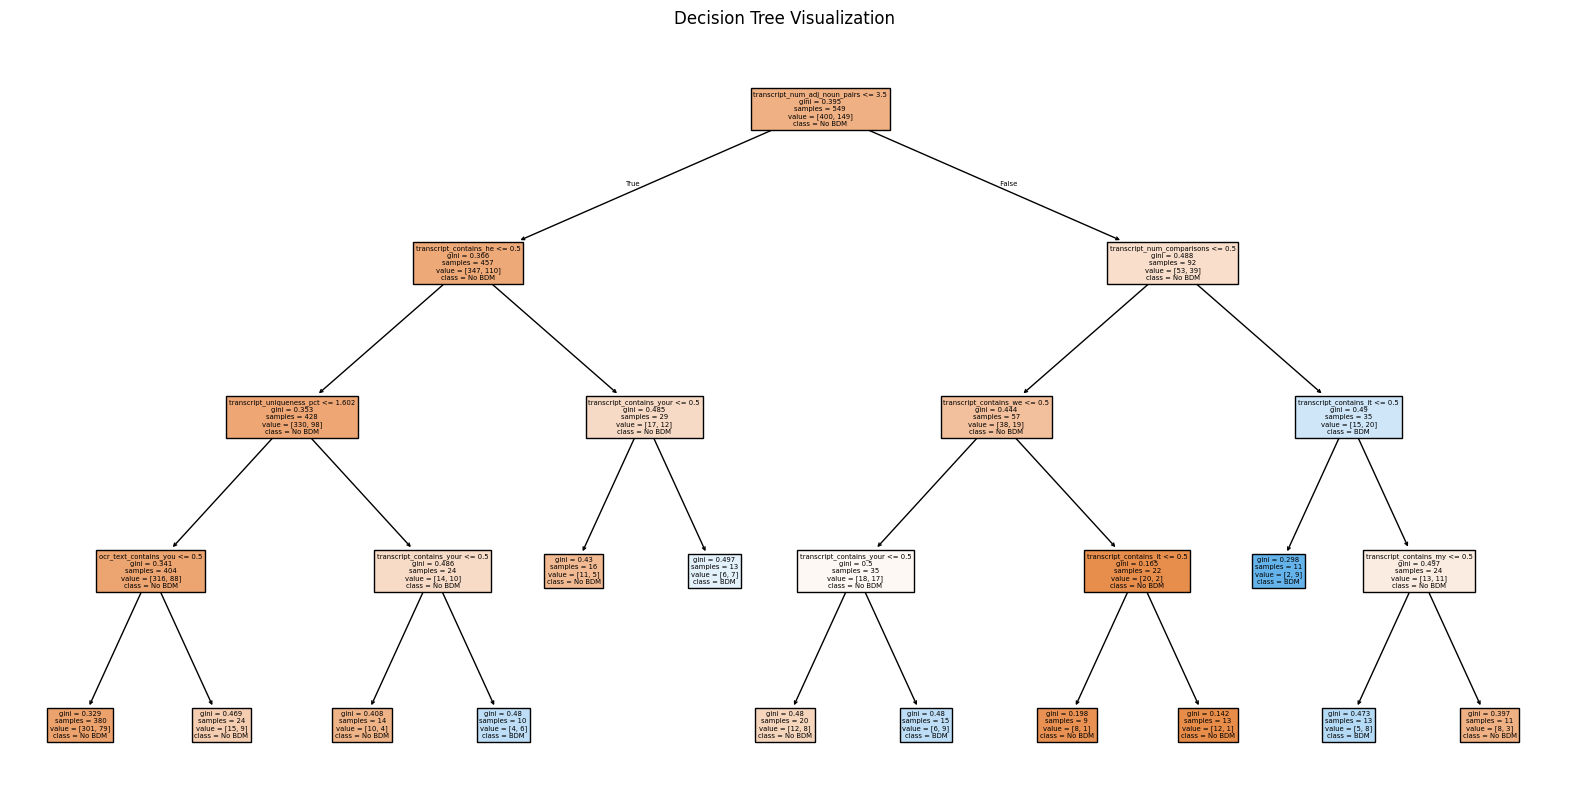

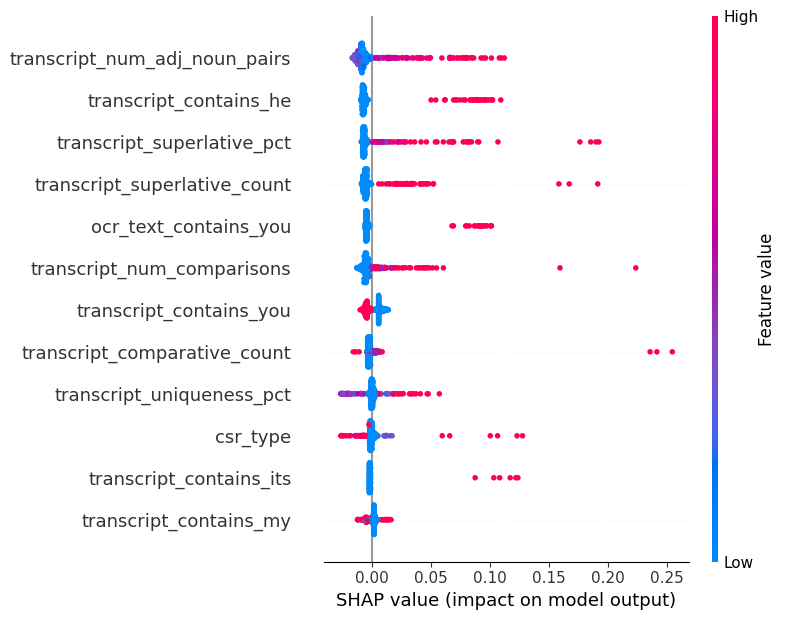

## Confusion Matrices:


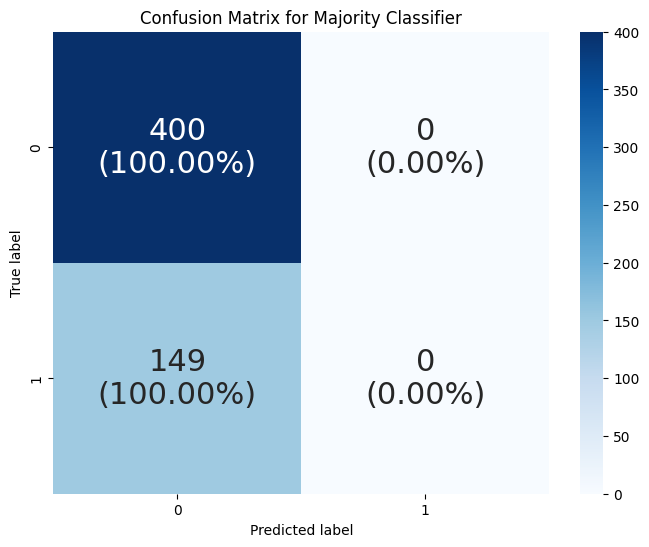

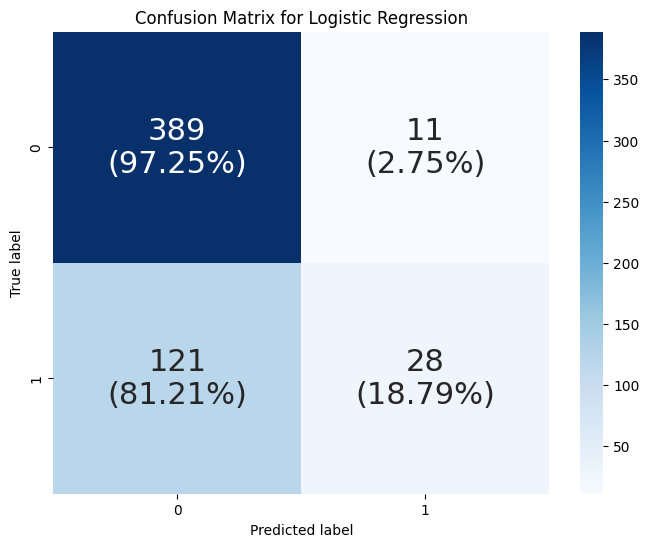

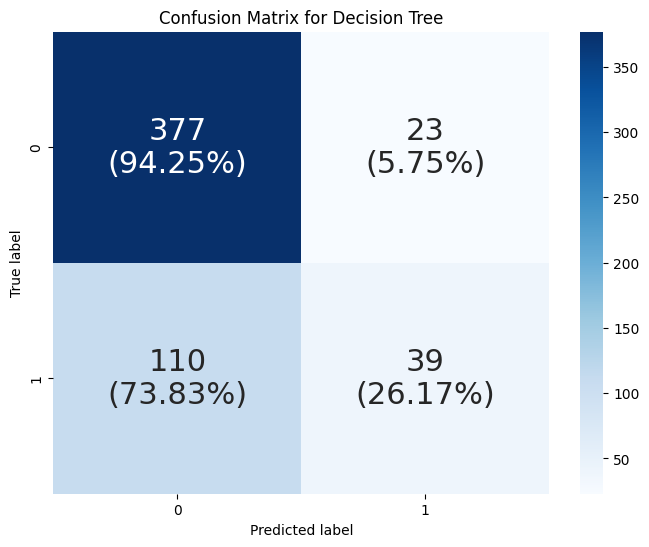

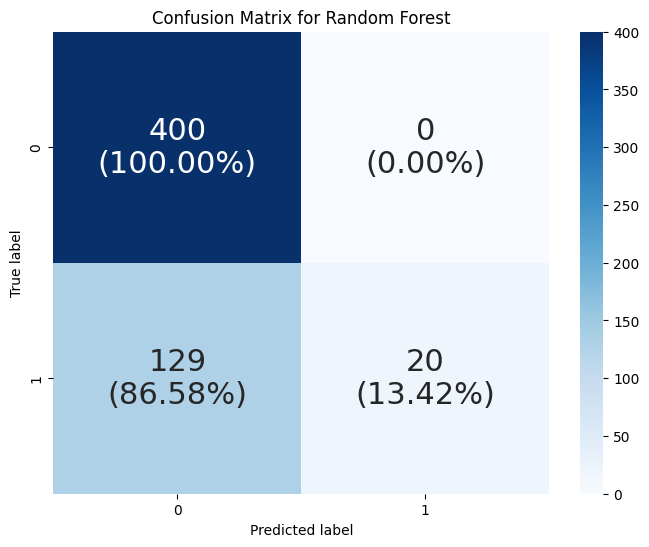

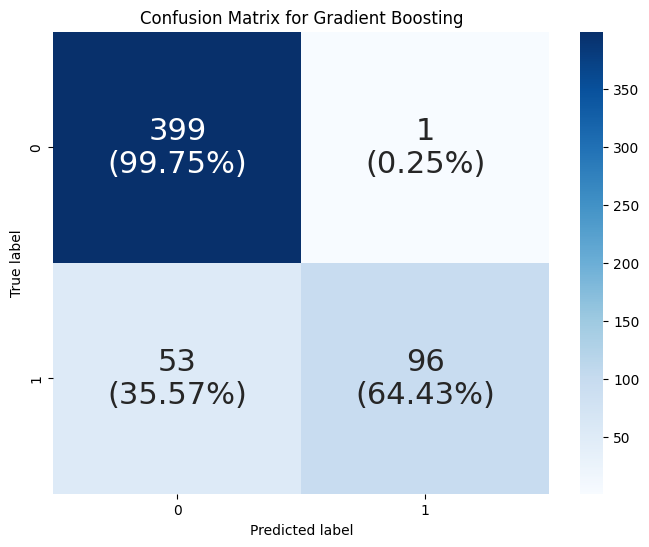

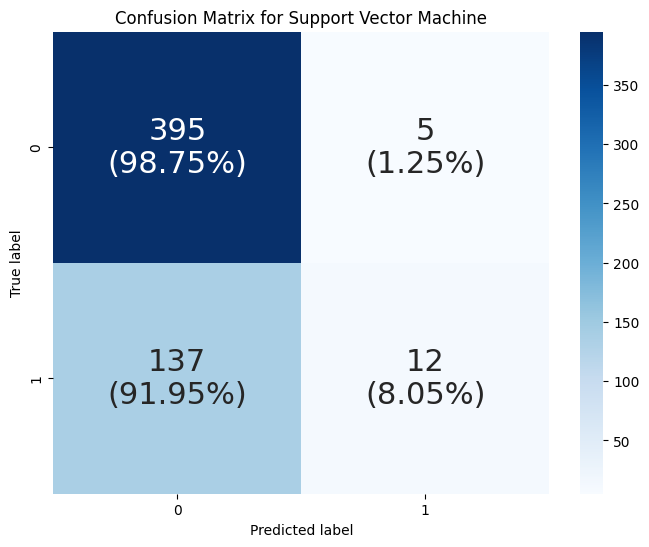

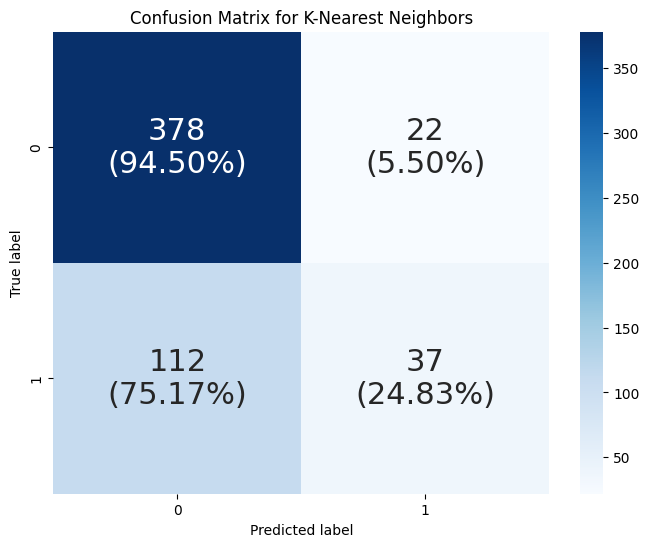

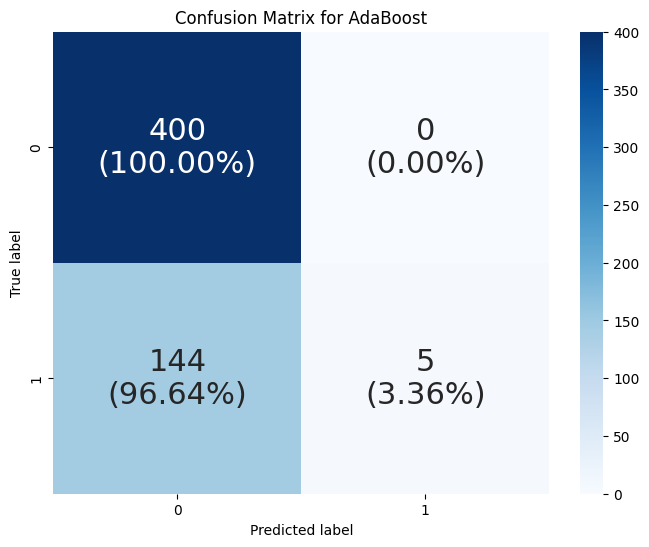

# industry_specific Model

Series([], dtype: int64)

✅ No missing values found


,csr_type,encoded_emotion,ocr_text_comparative_count,ocr_text_comparative_pct,ocr_text_contains_he,ocr_text_contains_her,ocr_text_contains_his,ocr_text_contains_i,ocr_text_contains_it,ocr_text_contains_its,...,transcript_contains_you,transcript_contains_your,transcript_contains_yours,transcript_num_adj_noun_pairs,transcript_num_comparisons,transcript_product_cat_keywords_similarity,transcript_superlative_count,transcript_superlative_pct,transcript_uniqueness_count,transcript_uniqueness_pct
0,0,0,0,0.0,0,0,0,0,0,0,...,1,1,0,0,1,0.255,0,0.00000,1,0.558659
1,0,1,0,0.0,0,0,0,0,0,0,...,0,1,0,0,0,0.000,0,0.00000,0,0.000000
2,0,0,0,0.0,0,0,0,0,0,0,...,1,1,0,2,2,0.354,0,0.00000,0,0.000000
3,0,0,0,0.0,0,0,0,0,1,0,...,1,0,0,1,1,0.289,0,0.00000,0,0.000000
4,0,0,0,0.0,0,0,0,0,0,0,...,1,0,0,0,0,0.000,0,0.00000,0,0.000000
5,0,0,0,0.0,0,0,0,0,0,0,...,0,0,0,5,0,0.356,1,2.12766,1,2.127660
6,0,0,0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0.244,0,0.00000,0,0.000000
7,0,0,0,0.0,0,0,0,0,0,0,...,0,0,0,4,0,0.172,0,0.00000,0,0.000000
8,0,0,0,0.0,0,0,0,0,0,0,...,1,1,0,0,0,0.156,0,0.00000,0,0.000000
9,0,0,0,0.0,0,0,0,0,0,0,...,0,0,0,1,1,0.340,0,0.00000,0,0.000000



Tuning Logistic Regression...
Best parameters: {'C': np.float64(9.83755518841459), 'penalty': 'l1', 'solver': 'liblinear'}
Best score: 0.525

Tuning Decision Tree...
Best parameters: {'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 12}
Best score: 0.564

Tuning Random Forest...
Best parameters: {'max_depth': 6, 'min_samples_split': 7, 'n_estimators': 179}
Best score: 0.600

Tuning Gradient Boosting...
Best parameters: {'learning_rate': np.float64(0.12562495076197483), 'max_depth': 4, 'n_estimators': 102}
Best score: 0.588

Tuning Support Vector Machine...
Best parameters: {'C': np.float64(3.768695797323276), 'kernel': 'linear'}
Best score: 0.550
Training Majority Classifier...
Training Logistic Regression...
Training Decision Tree...
Training Random Forest...
Training Gradient Boosting...
Training Support Vector Machine...
Training K-Nearest Neighbors...
Training AdaBoost...
Saving Majority Classifier to trained_models/Majority Classifier_industry.pkl
Saving Logistic Regre

## 5 Evaluation

Evaluating Majority Classifier...
Evaluating Logistic Regression...
Evaluating Decision Tree...
Evaluating Random Forest...


/home/arkastor/Development/Commercial-Brand-Differentiating-Message-Analysis/app/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/arkastor/Development/Commercial-Brand-Differentiating-Message-Analysis/app/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/arkastor/Development/Commercial-Brand-Differentiating-Message-Analysis/app/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to

Evaluating Gradient Boosting...
Evaluating Support Vector Machine...
Evaluating K-Nearest Neighbors...
Evaluating AdaBoost...


## Cross-Validation Results:


,Model,ROC AUC (Mean),ROC AUC (Std),Accuracy (Mean),Accuracy (Std),Precision (Mean),Precision (Std),Recall (Mean),Recall (Std)
3,Random Forest,0.600259,0.044337,0.728624,0.009899,0.400000,0.489898,0.013563,0.016615
4,Gradient Boosting,0.587889,0.025538,0.693995,0.020291,0.382518,0.035766,0.200920,0.075223
7,AdaBoost,0.565159,0.055571,0.728590,0.019485,0.542381,0.292027,0.073563,0.032380
2,Decision Tree,0.564302,0.066074,0.706756,0.017336,0.445238,0.279861,0.086897,0.053935
5,Support Vector Machine,0.550000,0.089909,0.704954,0.016232,0.140000,0.174356,0.033793,0.042536
1,Logistic Regression,0.524885,0.049193,0.719416,0.021351,0.464939,0.111534,0.180690,0.067843
6,K-Nearest Neighbors,0.511322,0.049260,0.683069,0.006270,0.272222,0.050918,0.107126,0.038408
0,Majority Classifier,0.500000,0.000000,0.728607,0.002669,0.000000,0.000000,0.000000,0.000000


## XAI:


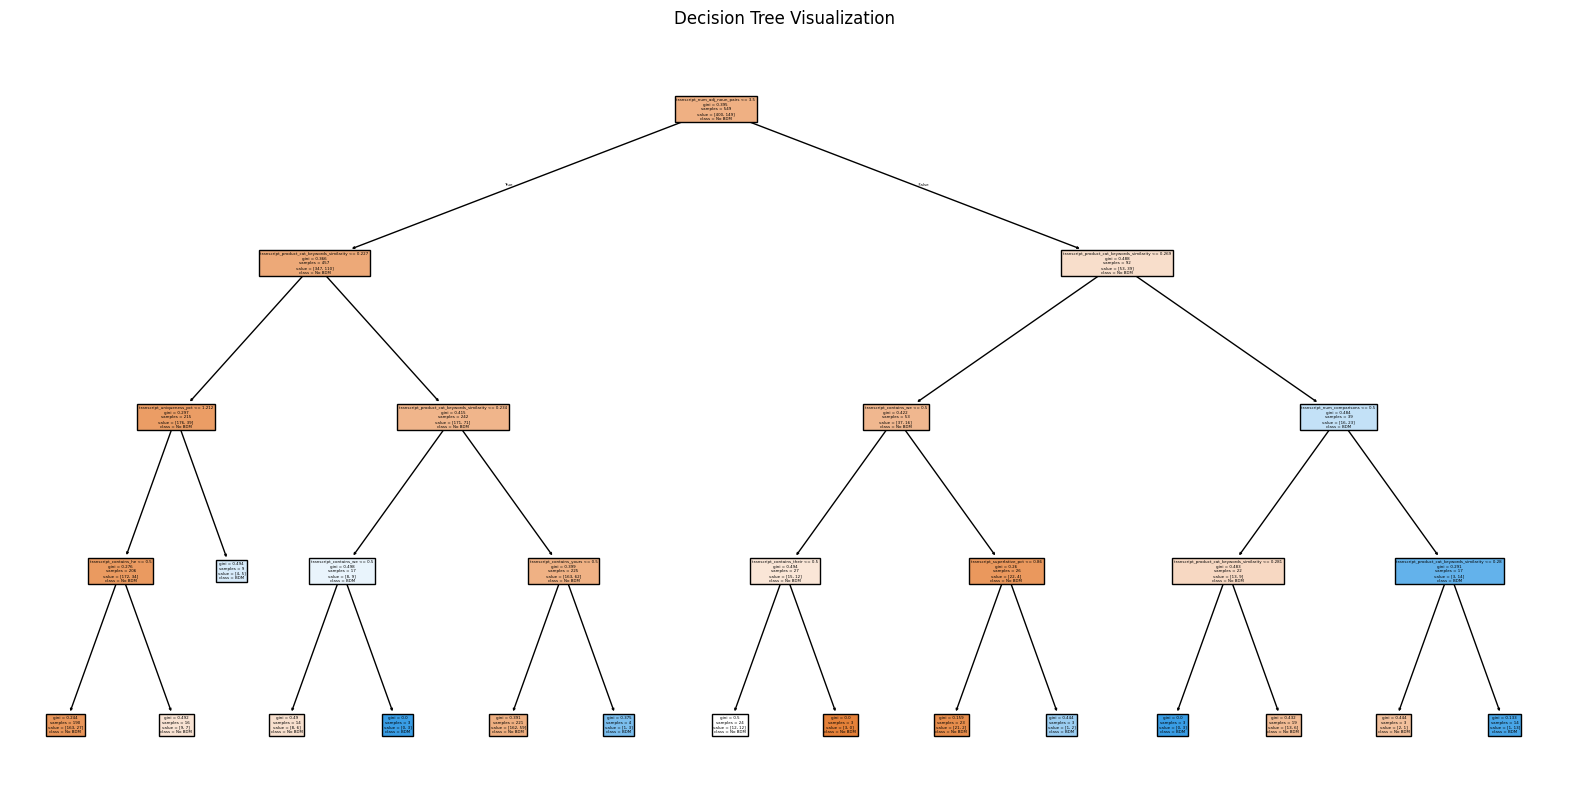

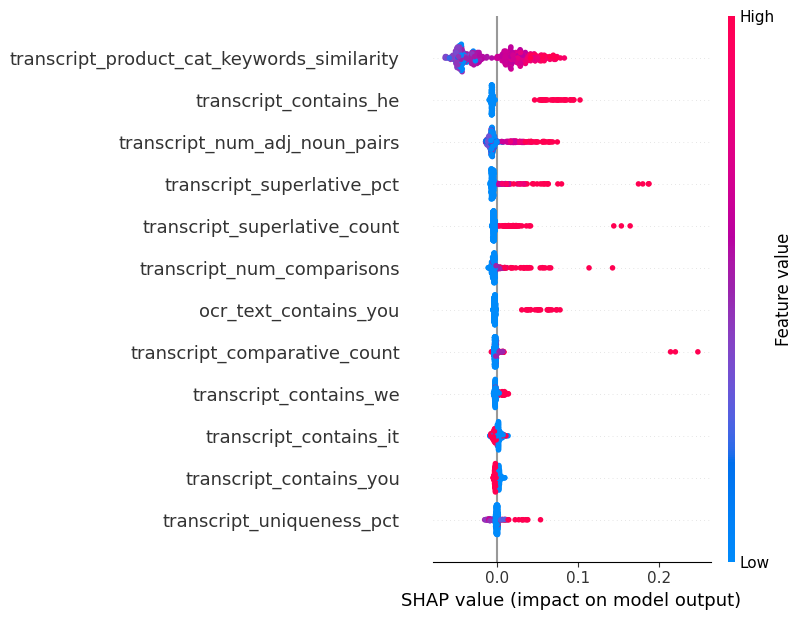

## Confusion Matrices:


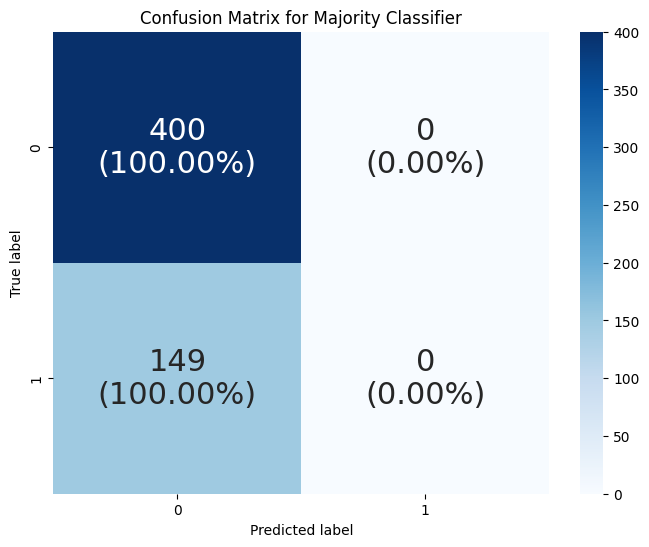

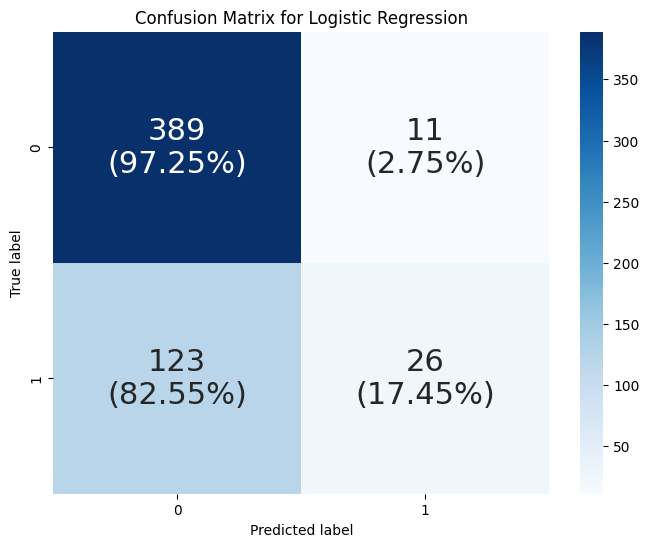

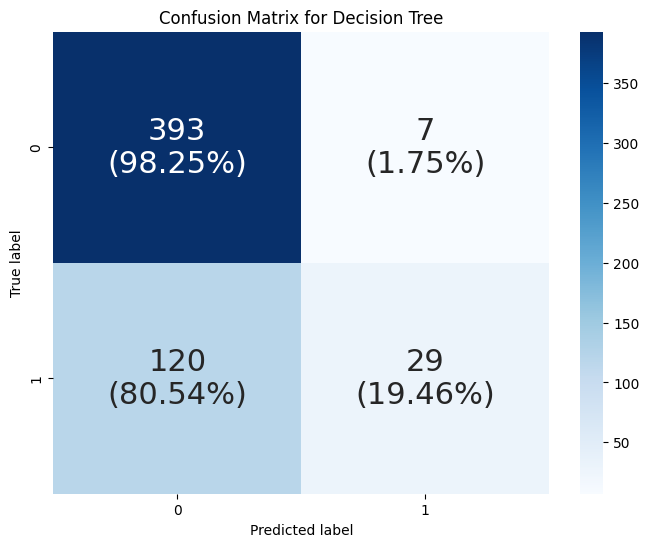

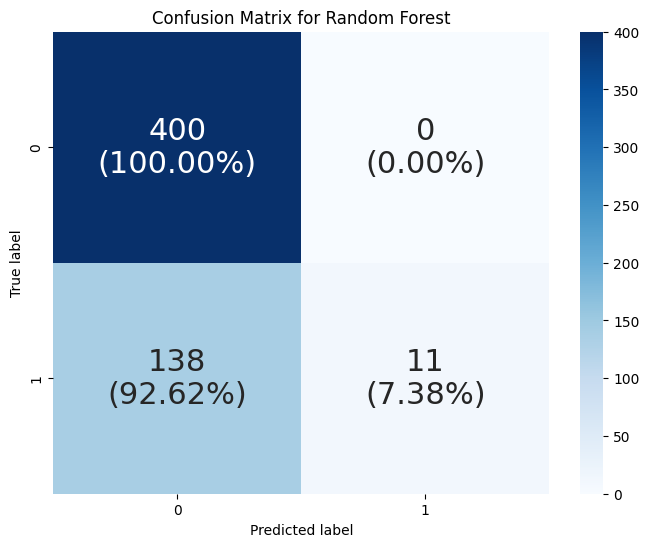

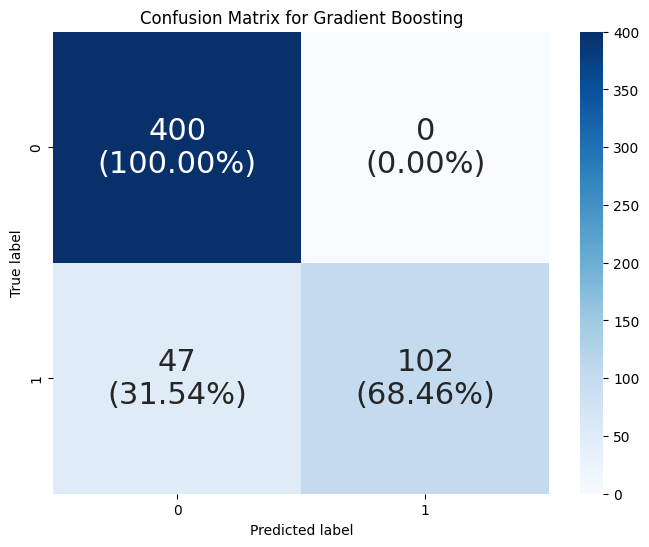

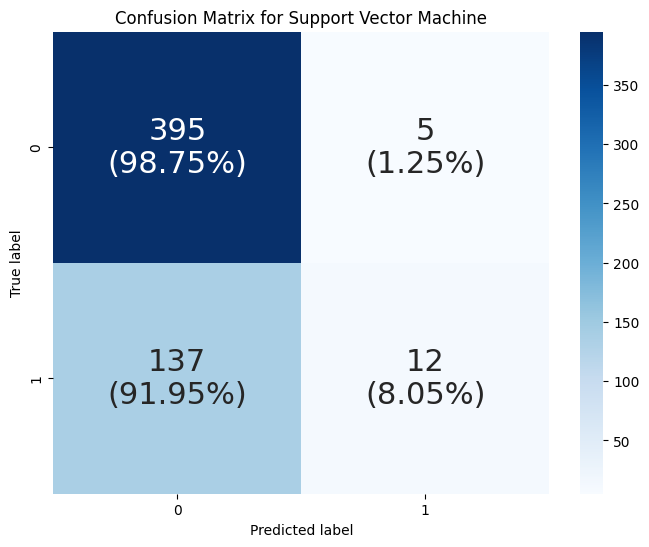

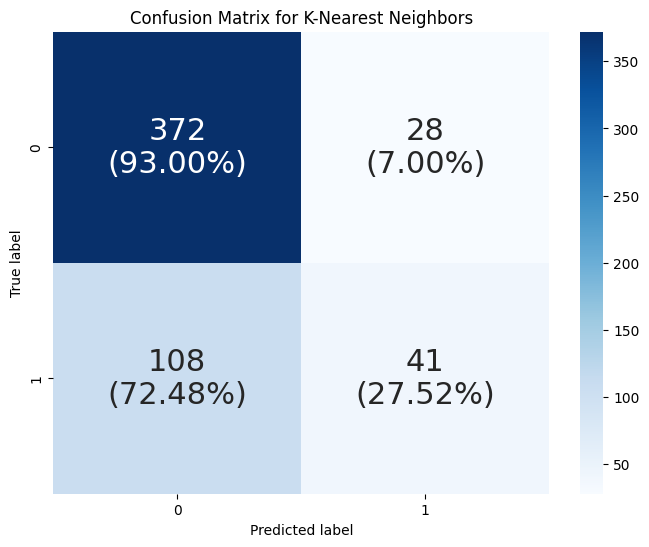

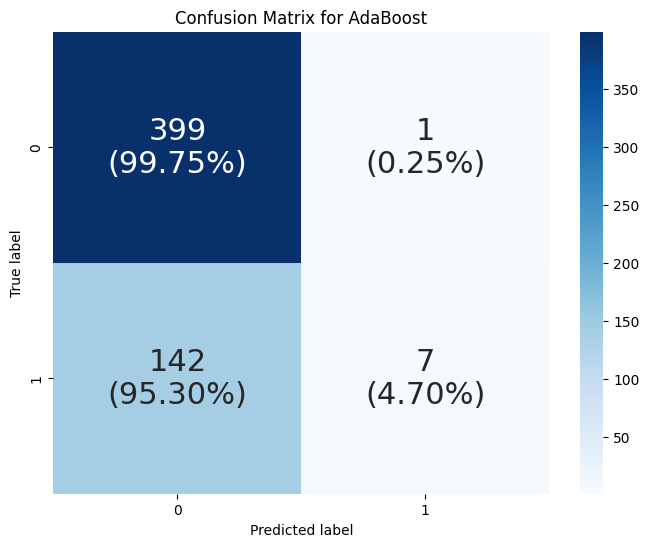

# brand_specific Model

Series([], dtype: int64)

✅ No missing values found


,csr_type,encoded_emotion,ocr_text_comparative_count,ocr_text_comparative_pct,ocr_text_contains_he,ocr_text_contains_her,ocr_text_contains_his,ocr_text_contains_i,ocr_text_contains_it,ocr_text_contains_its,...,transcript_contains_you,transcript_contains_your,transcript_contains_yours,transcript_num_adj_noun_pairs,transcript_num_comparisons,transcript_product_brand_keywords_similarity,transcript_superlative_count,transcript_superlative_pct,transcript_uniqueness_count,transcript_uniqueness_pct
0,0,0,0,0.0,0,0,0,0,0,0,...,1,1,0,0,1,0.186,0,0.00000,1,0.558659
5,0,0,0,0.0,0,0,0,0,0,0,...,0,0,0,5,0,0.257,1,2.12766,1,2.127660
6,0,0,0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0.227,0,0.00000,0,0.000000
7,0,0,0,0.0,0,0,0,0,0,0,...,0,0,0,4,0,0.082,0,0.00000,0,0.000000
8,0,0,0,0.0,0,0,0,0,0,0,...,1,1,0,0,0,0.125,0,0.00000,0,0.000000
22,0,0,0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0.000,0,0.00000,0,0.000000
23,0,0,0,0.0,0,0,0,0,0,0,...,1,0,0,0,1,0.094,0,0.00000,0,0.000000
24,0,0,0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0.111,0,0.00000,0,0.000000
25,2,0,0,0.0,0,0,0,0,0,0,...,1,1,0,2,0,0.141,0,0.00000,0,0.000000
39,0,0,0,0.0,0,0,0,0,0,0,...,1,0,0,2,1,0.271,0,0.00000,0,0.000000



Tuning Logistic Regression...
Best parameters: {'C': np.float64(4.419450186421157), 'penalty': 'l1', 'solver': 'liblinear'}
Best score: 0.620

Tuning Decision Tree...
Best parameters: {'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 12}
Best score: 0.678

Tuning Random Forest...
Best parameters: {'max_depth': 4, 'min_samples_split': 13, 'n_estimators': 138}
Best score: 0.643

Tuning Gradient Boosting...
Best parameters: {'learning_rate': np.float64(0.012119891565915222), 'max_depth': 3, 'n_estimators': 98}
Best score: 0.693

Tuning Support Vector Machine...
Best parameters: {'C': np.float64(16.748852816008437), 'kernel': 'linear'}
Best score: 0.609
Training Majority Classifier...
Training Logistic Regression...
Training Decision Tree...
Training Random Forest...
Training Gradient Boosting...
Training Support Vector Machine...
Training K-Nearest Neighbors...
Training AdaBoost...
Saving Majority Classifier to trained_models/Majority Classifier_brand.pkl
Saving Logistic Regre

## 5 Evaluation

Evaluating Majority Classifier...
Evaluating Logistic Regression...
Evaluating Decision Tree...
Evaluating Random Forest...


/home/arkastor/Development/Commercial-Brand-Differentiating-Message-Analysis/app/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/arkastor/Development/Commercial-Brand-Differentiating-Message-Analysis/app/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/arkastor/Development/Commercial-Brand-Differentiating-Message-Analysis/app/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to

Evaluating Gradient Boosting...
Evaluating Support Vector Machine...
Evaluating K-Nearest Neighbors...
Evaluating AdaBoost...


## Cross-Validation Results:


,Model,ROC AUC (Mean),ROC AUC (Std),Accuracy (Mean),Accuracy (Std),Precision (Mean),Precision (Std),Recall (Mean),Recall (Std)
4,Gradient Boosting,0.693031,0.032889,0.651829,0.020541,0.605803,0.026081,0.563399,0.090602
2,Decision Tree,0.678115,0.051373,0.612195,0.040692,0.592468,0.110105,0.461438,0.192942
3,Random Forest,0.643381,0.035363,0.597195,0.046602,0.561508,0.080839,0.312418,0.093022
7,AdaBoost,0.642439,0.075244,0.611829,0.049682,0.568262,0.074083,0.494771,0.059817
1,Logistic Regression,0.620068,0.041323,0.611829,0.058892,0.573815,0.092379,0.451634,0.122458
5,Support Vector Machine,0.608618,0.044514,0.572073,0.051361,0.511894,0.081123,0.383660,0.156966
6,K-Nearest Neighbors,0.553578,0.057904,0.522561,0.019893,0.433561,0.044440,0.358170,0.105259
0,Majority Classifier,0.500000,0.000000,0.567195,0.010170,0.000000,0.000000,0.000000,0.000000


## XAI:


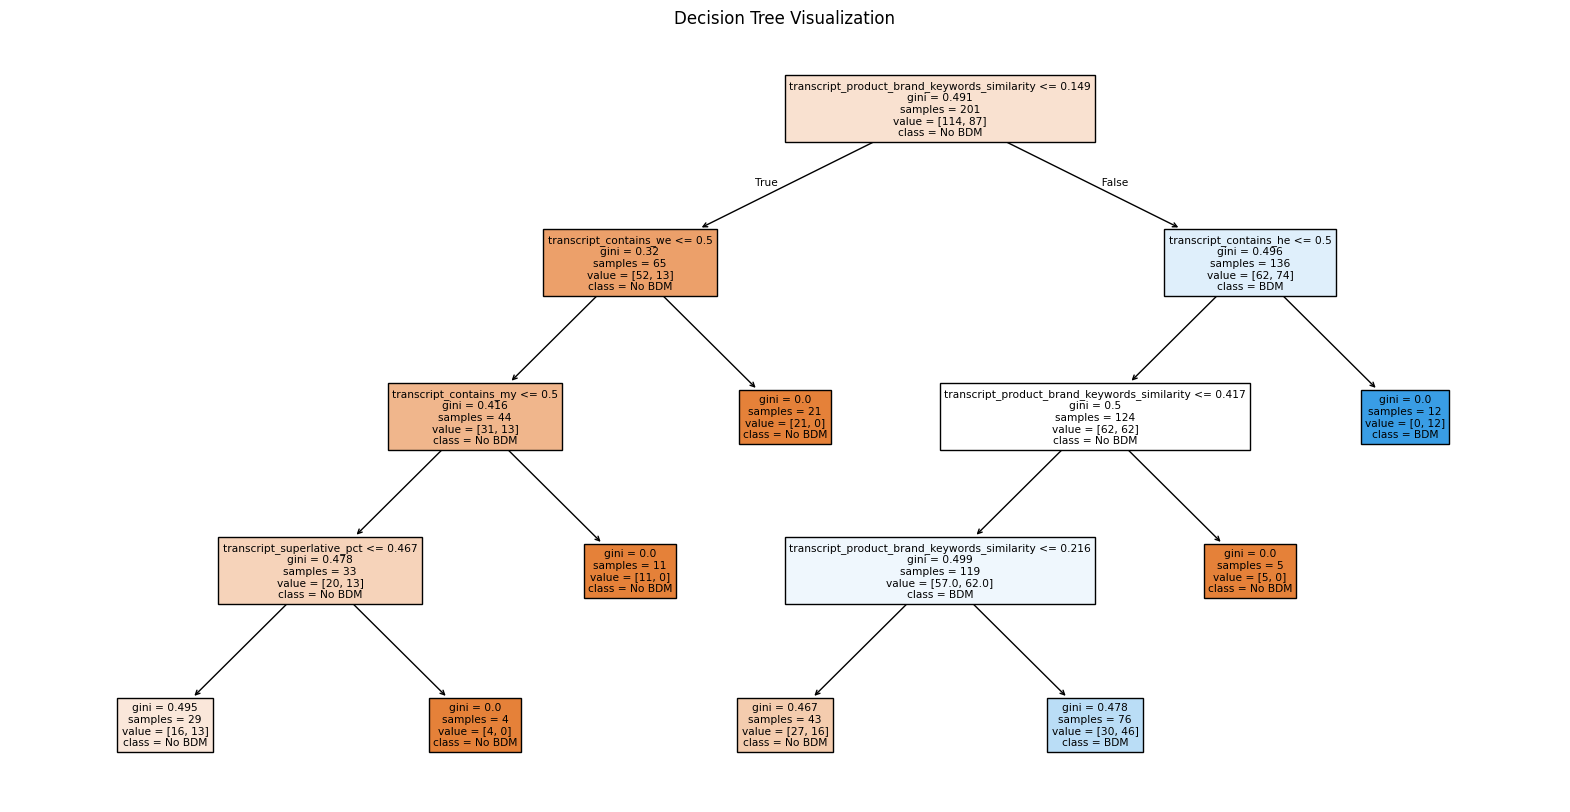

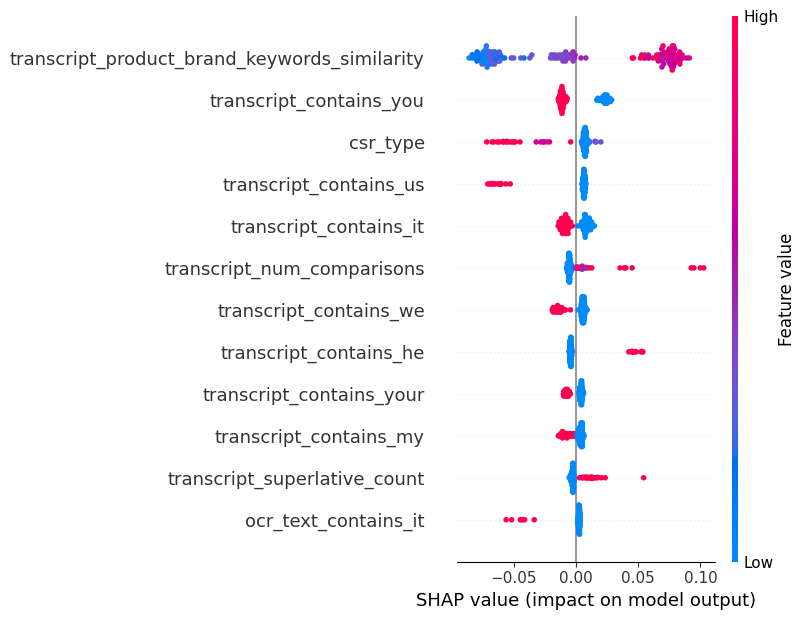

## Confusion Matrices:


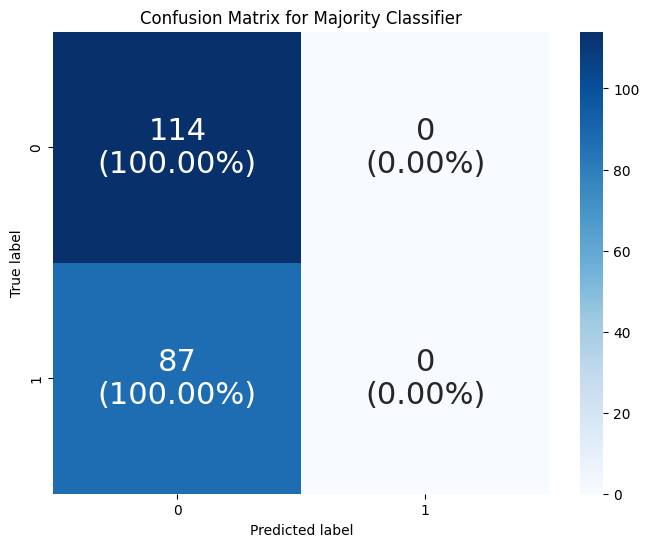

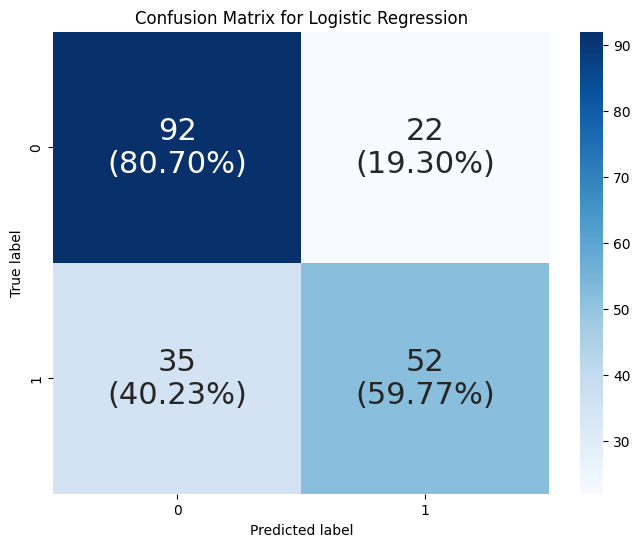

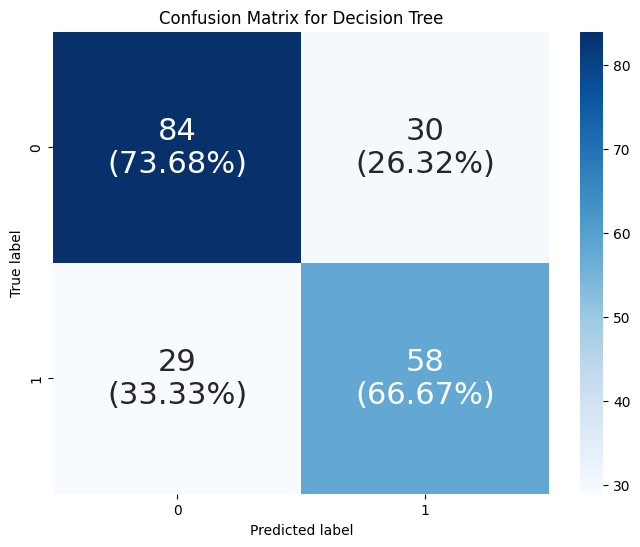

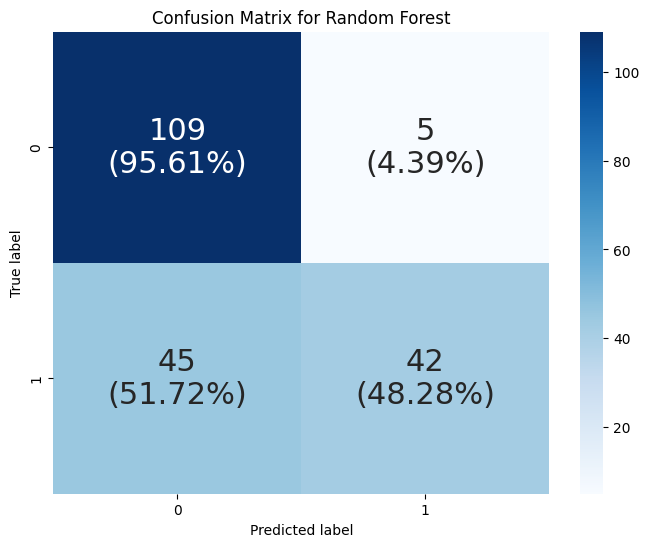

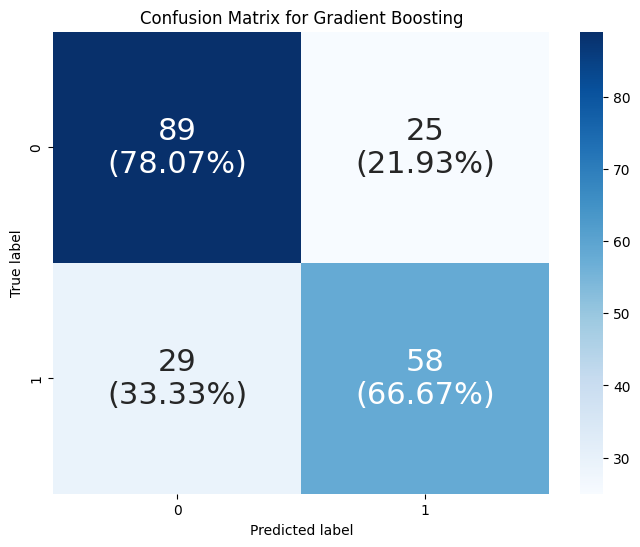

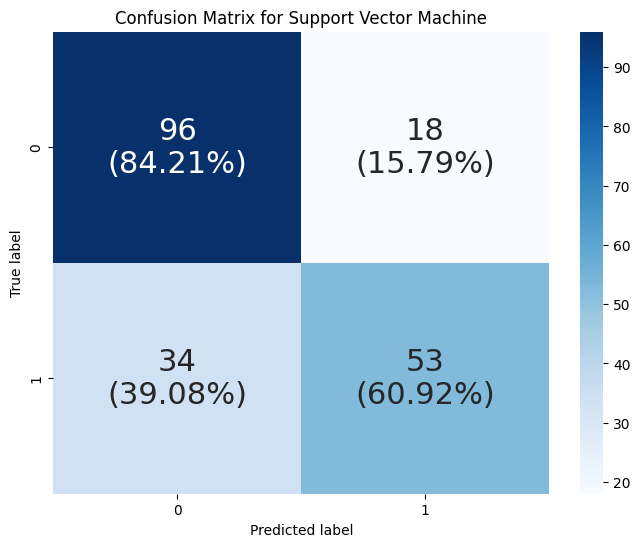

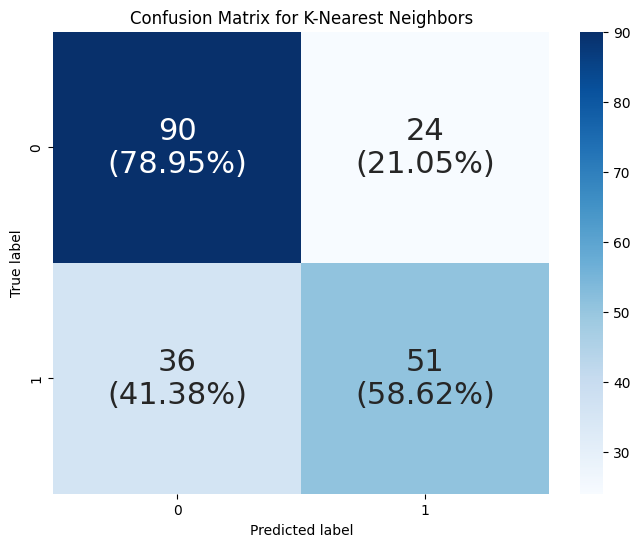

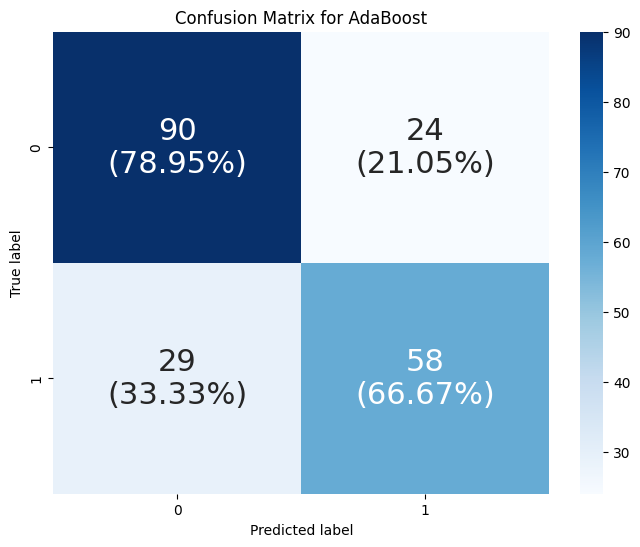

# industry_and_brand_specific Model

Series([], dtype: int64)

✅ No missing values found


,csr_type,encoded_emotion,ocr_text_comparative_count,ocr_text_comparative_pct,ocr_text_contains_he,ocr_text_contains_her,ocr_text_contains_his,ocr_text_contains_i,ocr_text_contains_it,ocr_text_contains_its,...,transcript_contains_your,transcript_contains_yours,transcript_num_adj_noun_pairs,transcript_num_comparisons,transcript_product_brand_keywords_similarity,transcript_product_cat_keywords_similarity,transcript_superlative_count,transcript_superlative_pct,transcript_uniqueness_count,transcript_uniqueness_pct
0,0,0,0,0.0,0,0,0,0,0,0,...,1,0,0,1,0.186,0.255,0,0.00000,1,0.558659
5,0,0,0,0.0,0,0,0,0,0,0,...,0,0,5,0,0.257,0.356,1,2.12766,1,2.127660
6,0,0,0,0.0,0,0,0,0,0,0,...,0,0,0,0,0.227,0.244,0,0.00000,0,0.000000
7,0,0,0,0.0,0,0,0,0,0,0,...,0,0,4,0,0.082,0.172,0,0.00000,0,0.000000
8,0,0,0,0.0,0,0,0,0,0,0,...,1,0,0,0,0.125,0.156,0,0.00000,0,0.000000
22,0,0,0,0.0,0,0,0,0,0,0,...,0,0,0,0,0.000,0.000,0,0.00000,0,0.000000
23,0,0,0,0.0,0,0,0,0,0,0,...,0,0,0,1,0.094,0.233,0,0.00000,0,0.000000
24,0,0,0,0.0,0,0,0,0,0,0,...,0,0,0,0,0.111,0.244,0,0.00000,0,0.000000
25,2,0,0,0.0,0,0,0,0,0,0,...,1,0,2,0,0.141,0.258,0,0.00000,0,0.000000
39,0,0,0,0.0,0,0,0,0,0,0,...,0,0,2,1,0.271,0.271,0,0.00000,0,0.000000



Tuning Logistic Regression...
Best parameters: {'C': np.float64(6.086584841970366), 'penalty': 'l1', 'solver': 'liblinear'}
Best score: 0.620

Tuning Decision Tree...
Best parameters: {'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 12}
Best score: 0.666

Tuning Random Forest...
Best parameters: {'max_depth': 3, 'min_samples_split': 11, 'n_estimators': 269}
Best score: 0.652

Tuning Gradient Boosting...
Best parameters: {'learning_rate': np.float64(0.012119891565915222), 'max_depth': 3, 'n_estimators': 98}
Best score: 0.665

Tuning Support Vector Machine...
Best parameters: {'C': np.float64(16.748852816008437), 'kernel': 'linear'}
Best score: 0.605
Training Majority Classifier...
Training Logistic Regression...
Training Decision Tree...
Training Random Forest...
Training Gradient Boosting...
Training Support Vector Machine...
Training K-Nearest Neighbors...
Training AdaBoost...
Saving Majority Classifier to trained_models/Majority Classifier_industry_brand.pkl
Saving Logis

## 5 Evaluation

Evaluating Majority Classifier...
Evaluating Logistic Regression...
Evaluating Decision Tree...
Evaluating Random Forest...


/home/arkastor/Development/Commercial-Brand-Differentiating-Message-Analysis/app/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/arkastor/Development/Commercial-Brand-Differentiating-Message-Analysis/app/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/arkastor/Development/Commercial-Brand-Differentiating-Message-Analysis/app/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to

Evaluating Gradient Boosting...
Evaluating Support Vector Machine...
Evaluating K-Nearest Neighbors...
Evaluating AdaBoost...


## Cross-Validation Results:


,Model,ROC AUC (Mean),ROC AUC (Std),Accuracy (Mean),Accuracy (Std),Precision (Mean),Precision (Std),Recall (Mean),Recall (Std)
2,Decision Tree,0.665952,0.092077,0.592805,0.080659,0.553493,0.087540,0.560784,0.201384
4,Gradient Boosting,0.665075,0.049496,0.627073,0.028458,0.589912,0.056443,0.493464,0.141636
3,Random Forest,0.652134,0.037970,0.602073,0.020336,0.589683,0.039492,0.277124,0.072381
7,AdaBoost,0.634367,0.085119,0.611951,0.033559,0.564884,0.047612,0.495425,0.081676
1,Logistic Regression,0.620024,0.045108,0.606829,0.066607,0.562906,0.107760,0.440523,0.139116
5,Support Vector Machine,0.604720,0.044828,0.581951,0.044083,0.532500,0.086619,0.394771,0.142514
6,K-Nearest Neighbors,0.525850,0.051441,0.507805,0.037851,0.411538,0.048718,0.310458,0.028036
0,Majority Classifier,0.500000,0.000000,0.567195,0.010170,0.000000,0.000000,0.000000,0.000000


## XAI:


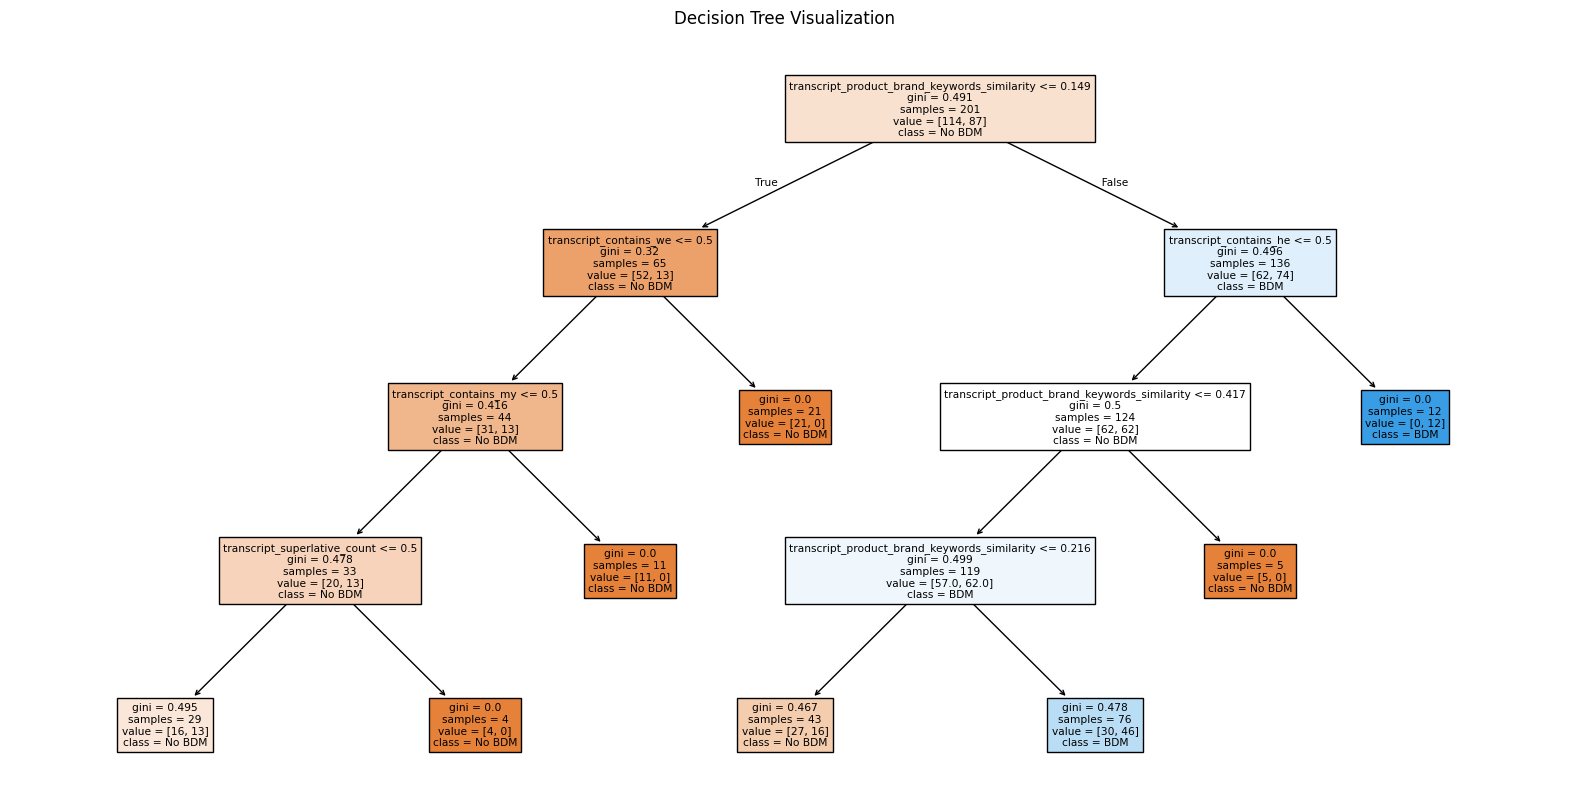

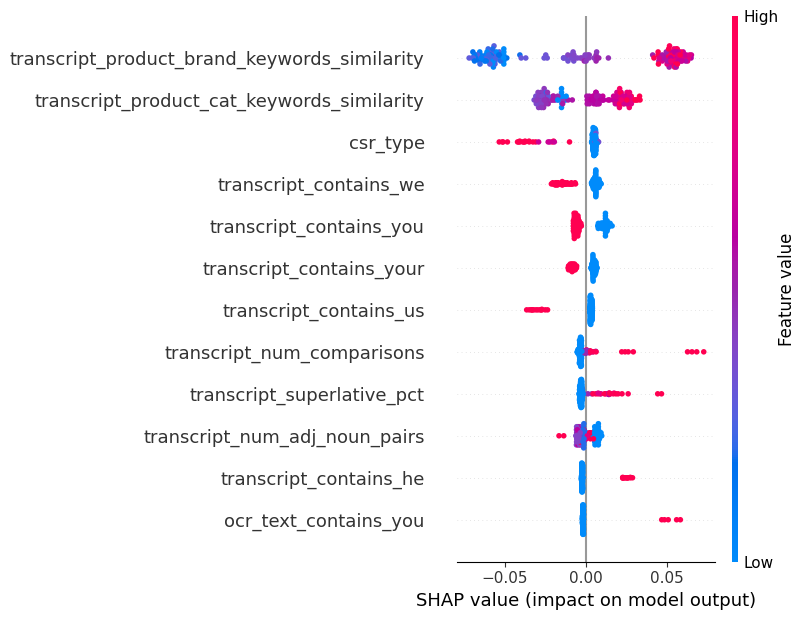

## Confusion Matrices:


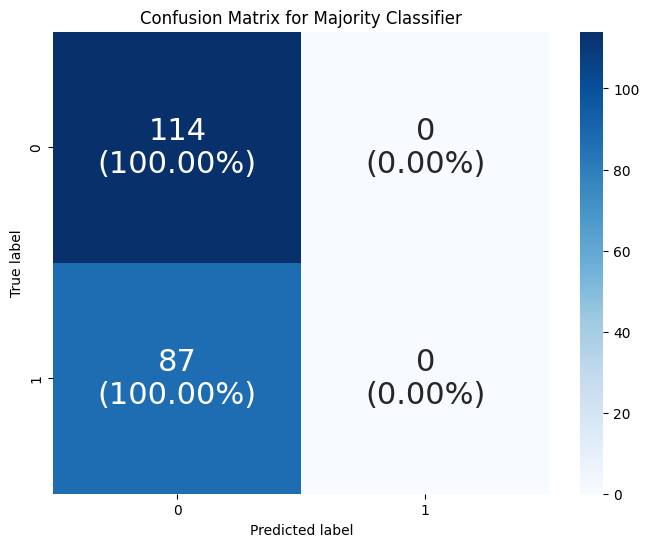

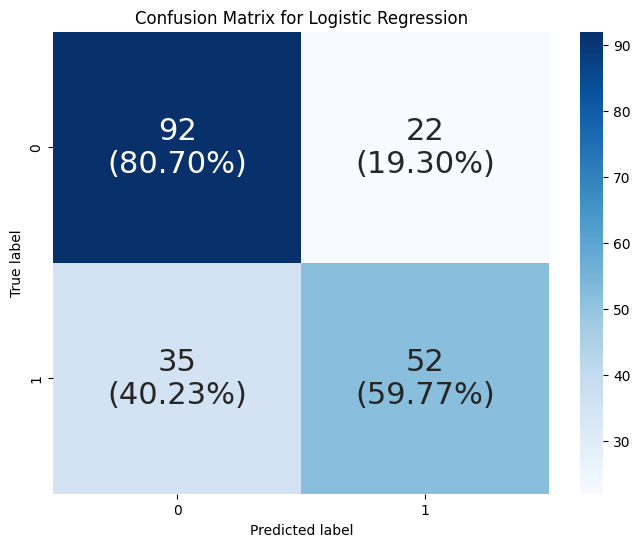

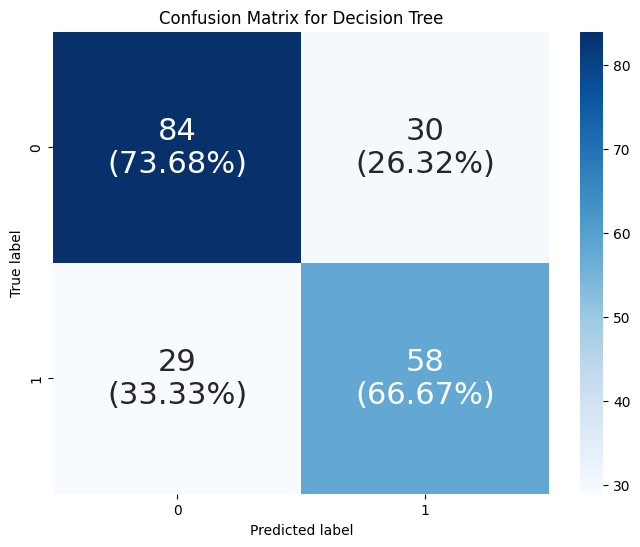

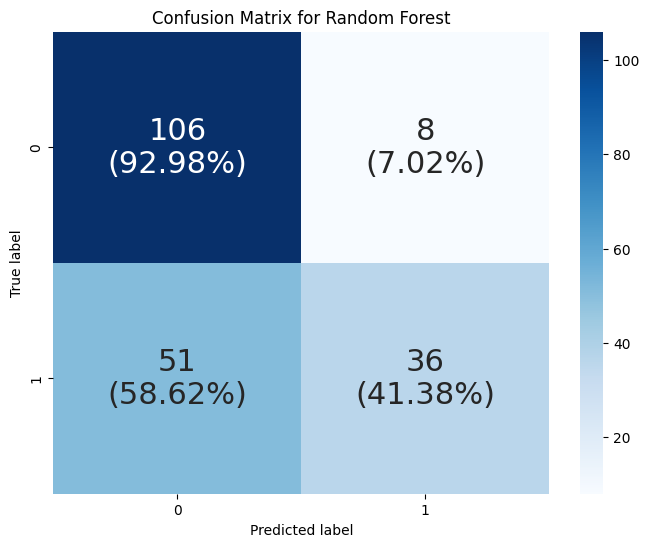

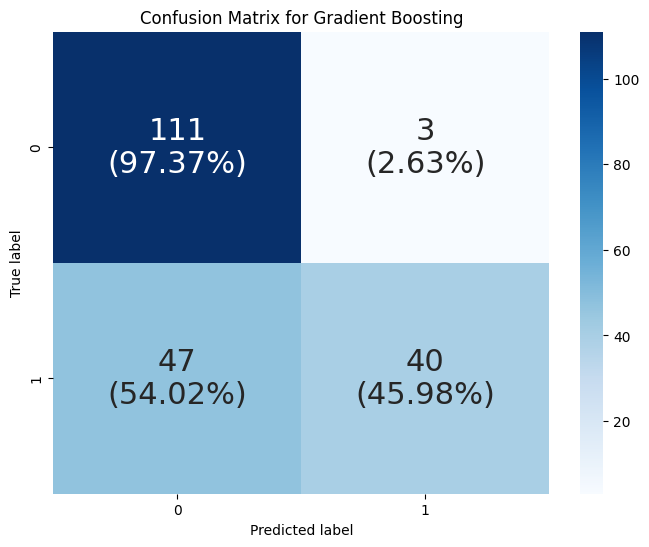

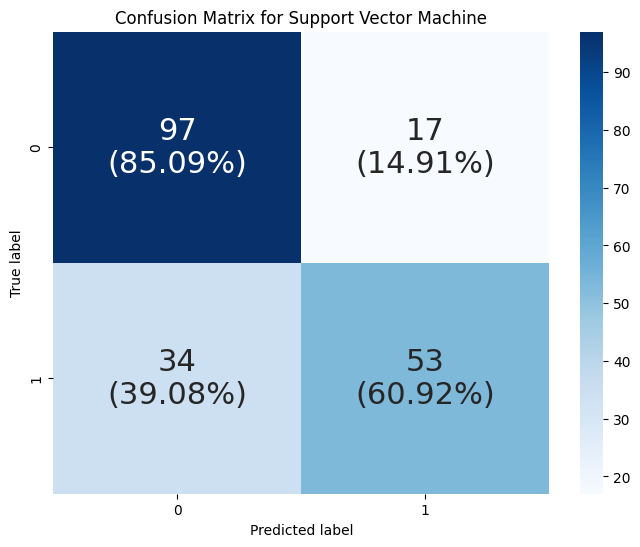

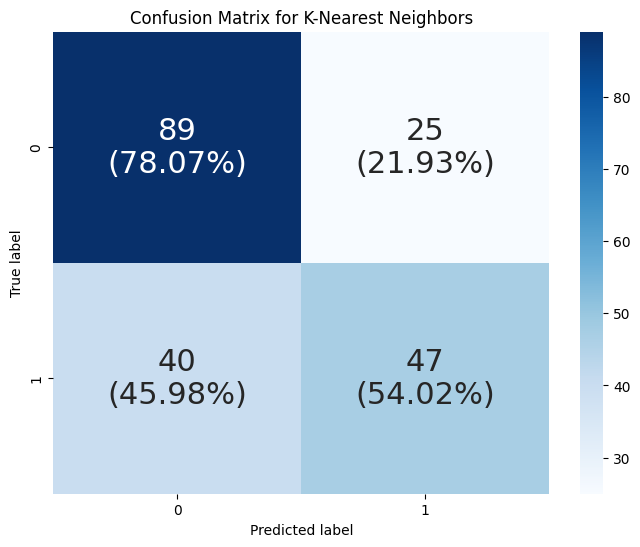

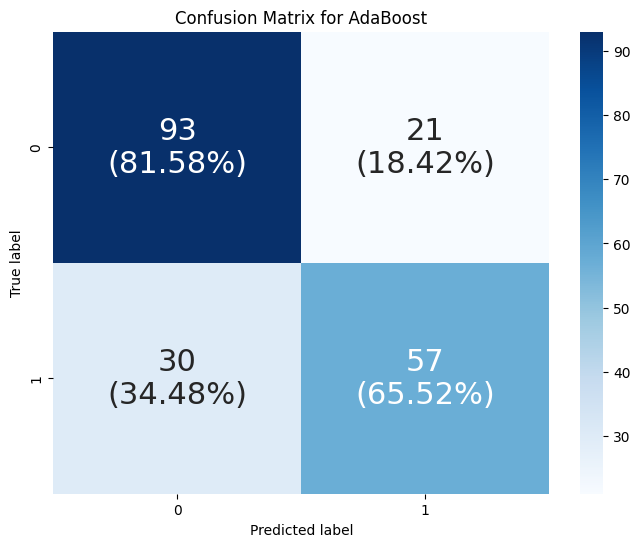

In [34]:

from IPython.display import Markdown
import models as m

for dataset in datasets:
    display(Markdown(f"# {dataset['name']} Model"))
    check_missing_values(dataset["df"])
    ad_df = dataset["df"]
    commercial_numbers = ad_df['commercial_number']
    ad_df = ad_df.drop(columns=['commercial_number'])
    original_data = ad_df.copy()

    target = ad_df['BDM']
    data = ad_df
    data.drop(columns=['BDM'], inplace=True)
    display(data.head(10))


    X_train, X_test, y_train, y_test = m.train_test_split(data, target, test_size=0.2, random_state=42)

    base_models = m.get_base_models()
    param_distributions = m.get_param_distributions()
    tuned_models = m.tune_models(data, target, base_models, param_distributions)



    trained_models = m.train_models(data, target, tuned_models, dataset["industry_specific"], dataset["brand_specific"])

    display(Markdown(f"## 5 Evaluation"))
    
    results_df, predictions = m.evaluate_models(data, target, trained_models)
    m.display_model_results(data, target, trained_models, results_df, predictions)
